In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 5

***
## load and prepare data

In [4]:
!ls ../data/processed/dsv02

dataset-metadata.json  test.parquet  train.parquet


In [5]:
train = pd.read_parquet("../data/processed/dsv02/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
categ_feats = [
    'B_30_first', 'B_38_first', 'D_114_first', 'D_116_first', 'D_117_first', 
    'D_120_first', 'D_126_first', 'D_63_first', 'D_64_first', 'D_66_first', 'D_68_first',
    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
]
len(input_feats)

1562

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
train = train.reset_index()

del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 2000,
    'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold")
        valid_df = dataframe.query("fold == @fold")
        
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            categorical_feature=categ_feats,
            free_raw_data=True,
        )
        
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=1500,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
            
        models.append(model)
        del train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
glob("../data/processed/cv*.parquet")

['../data/processed/cv1.parquet',
 '../data/processed/cv2.parquet',
 '../data/processed/cv4.parquet',
 '../data/processed/cv0.parquet',
 '../data/processed/cv3.parquet']

############################### repeated cross-validation step: 1/5 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[50]	valid_0's amex_metric: 0.766554	valid_0's recall_at4: 0.624337	valid_0's norm_gini: 0.90877


[100]	valid_0's amex_metric: 0.778861	valid_0's recall_at4: 0.641757	valid_0's norm_gini: 0.915965


[150]	valid_0's amex_metric: 0.784959	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.919578


[200]	valid_0's amex_metric: 0.78859	valid_0's recall_at4: 0.655685	valid_0's norm_gini: 0.921496


[250]	valid_0's amex_metric: 0.791018	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.922607


[300]	valid_0's amex_metric: 0.793019	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.923327


[350]	valid_0's amex_metric: 0.793399	valid_0's recall_at4: 0.663006	valid_0's norm_gini: 0.923791


[400]	valid_0's amex_metric: 0.794354	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.924188


[450]	valid_0's amex_metric: 0.794467	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.924455


[500]	valid_0's amex_metric: 0.795416	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.924669


[550]	valid_0's amex_metric: 0.796052	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.924807


[600]	valid_0's amex_metric: 0.79587	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.924905


[650]	valid_0's amex_metric: 0.796608	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.924993


[700]	valid_0's amex_metric: 0.796924	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.925077


[750]	valid_0's amex_metric: 0.797294	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925143


[800]	valid_0's amex_metric: 0.797338	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.92519


[850]	valid_0's amex_metric: 0.797513	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.925246


[900]	valid_0's amex_metric: 0.797546	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925269


[950]	valid_0's amex_metric: 0.797559	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925296


[1000]	valid_0's amex_metric: 0.797144	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.92535


[1050]	valid_0's amex_metric: 0.79672	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925385


[1100]	valid_0's amex_metric: 0.796895	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.92544


[1150]	valid_0's amex_metric: 0.797014	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.92551


[1200]	valid_0's amex_metric: 0.797781	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925529


[1250]	valid_0's amex_metric: 0.797506	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925527


[1300]	valid_0's amex_metric: 0.796831	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925523


[1350]	valid_0's amex_metric: 0.797005	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.925535


[1400]	valid_0's amex_metric: 0.7964	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925502


[1450]	valid_0's amex_metric: 0.795989	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.925479


[1500]	valid_0's amex_metric: 0.796052	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.925479


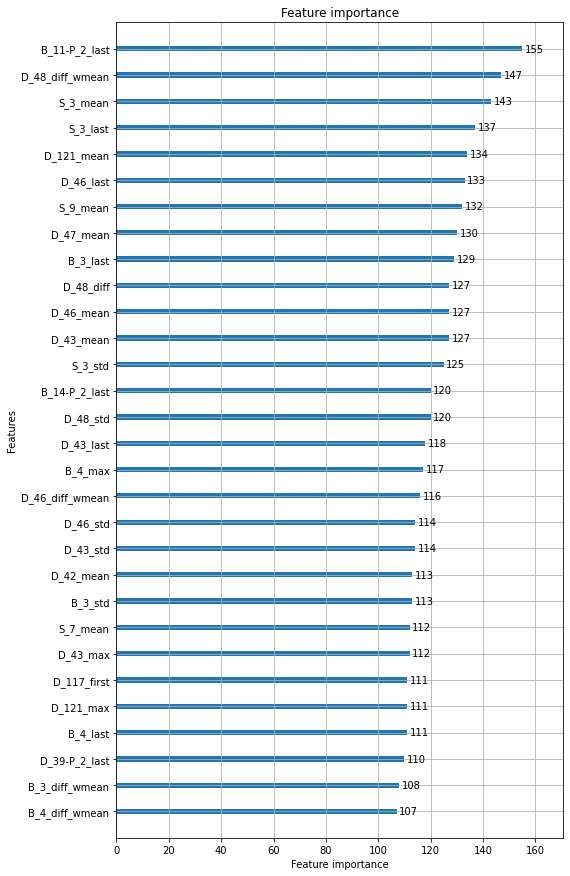

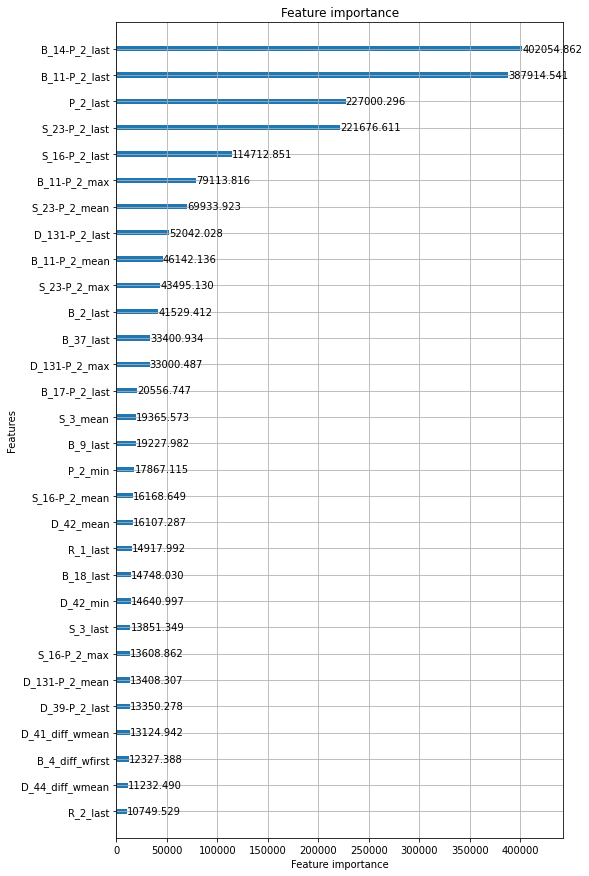

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.763797	valid_0's recall_at4: 0.619835	valid_0's norm_gini: 0.907758


[100]	valid_0's amex_metric: 0.775927	valid_0's recall_at4: 0.637002	valid_0's norm_gini: 0.914851


[150]	valid_0's amex_metric: 0.783439	valid_0's recall_at4: 0.648195	valid_0's norm_gini: 0.918683


[200]	valid_0's amex_metric: 0.786843	valid_0's recall_at4: 0.653034	valid_0's norm_gini: 0.920653


[250]	valid_0's amex_metric: 0.789532	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.921823


[300]	valid_0's amex_metric: 0.790573	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.922642


[350]	valid_0's amex_metric: 0.792393	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923168


[400]	valid_0's amex_metric: 0.793319	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.923548


[450]	valid_0's amex_metric: 0.793825	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.923844


[500]	valid_0's amex_metric: 0.794596	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.924124


[550]	valid_0's amex_metric: 0.795102	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.92438


[600]	valid_0's amex_metric: 0.795515	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924574


[650]	valid_0's amex_metric: 0.795279	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.92469


[700]	valid_0's amex_metric: 0.795778	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924805


[750]	valid_0's amex_metric: 0.796048	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.924841


[800]	valid_0's amex_metric: 0.795698	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924939


[850]	valid_0's amex_metric: 0.796238	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924968


[900]	valid_0's amex_metric: 0.795682	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.924991


[950]	valid_0's amex_metric: 0.795628	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.925053


[1000]	valid_0's amex_metric: 0.795794	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.925131


[1050]	valid_0's amex_metric: 0.796058	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.925156


[1100]	valid_0's amex_metric: 0.795821	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.925186


[1150]	valid_0's amex_metric: 0.795415	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.925215


[1200]	valid_0's amex_metric: 0.7958	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.925228


[1250]	valid_0's amex_metric: 0.79606	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.925242


[1300]	valid_0's amex_metric: 0.796284	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925271


[1350]	valid_0's amex_metric: 0.796051	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.925268


[1400]	valid_0's amex_metric: 0.796285	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925271


[1450]	valid_0's amex_metric: 0.796383	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.9253


[1500]	valid_0's amex_metric: 0.797091	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925285


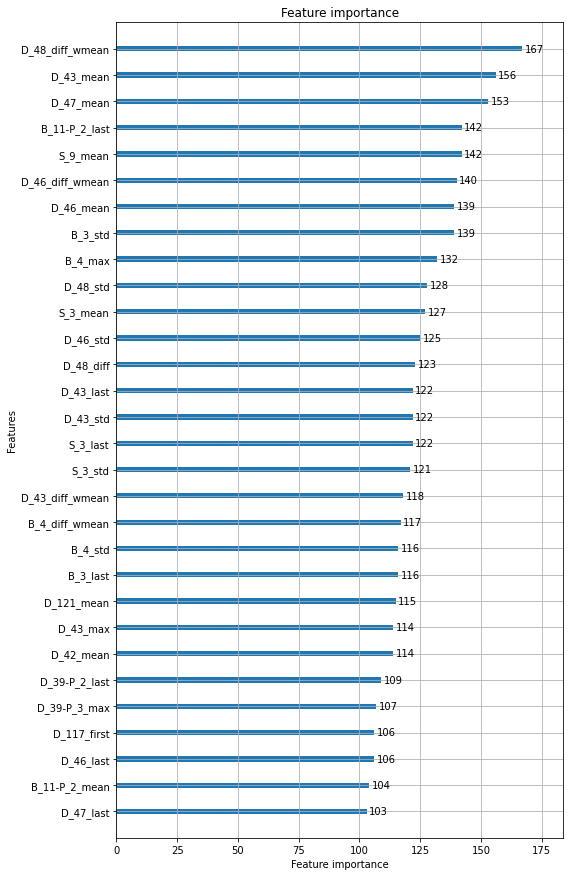

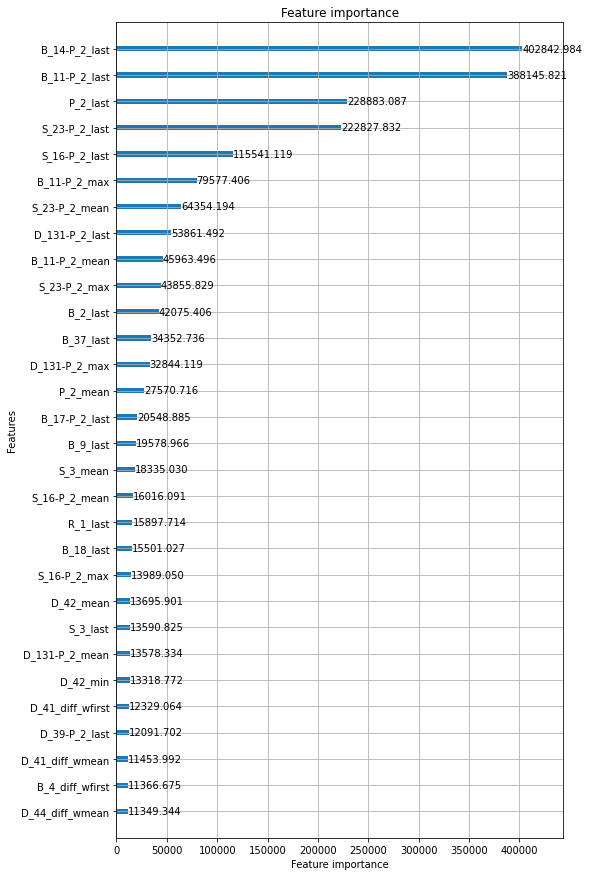

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.759555	valid_0's recall_at4: 0.612009	valid_0's norm_gini: 0.9071


[100]	valid_0's amex_metric: 0.771433	valid_0's recall_at4: 0.629008	valid_0's norm_gini: 0.913858


[150]	valid_0's amex_metric: 0.778461	valid_0's recall_at4: 0.639569	valid_0's norm_gini: 0.917354


[200]	valid_0's amex_metric: 0.78213	valid_0's recall_at4: 0.644955	valid_0's norm_gini: 0.919305


[250]	valid_0's amex_metric: 0.783232	valid_0's recall_at4: 0.646049	valid_0's norm_gini: 0.920414


[300]	valid_0's amex_metric: 0.78501	valid_0's recall_at4: 0.648868	valid_0's norm_gini: 0.921151


[350]	valid_0's amex_metric: 0.786363	valid_0's recall_at4: 0.651056	valid_0's norm_gini: 0.921669


[400]	valid_0's amex_metric: 0.786919	valid_0's recall_at4: 0.651771	valid_0's norm_gini: 0.922067


[450]	valid_0's amex_metric: 0.787659	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.922327


[500]	valid_0's amex_metric: 0.787711	valid_0's recall_at4: 0.652865	valid_0's norm_gini: 0.922557


[550]	valid_0's amex_metric: 0.788658	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.922767


[600]	valid_0's amex_metric: 0.789468	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.922958


[650]	valid_0's amex_metric: 0.788863	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.923051


[700]	valid_0's amex_metric: 0.789742	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.923169


[750]	valid_0's amex_metric: 0.7897	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.923252


[800]	valid_0's amex_metric: 0.789656	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.923333


[850]	valid_0's amex_metric: 0.790078	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.923419


[900]	valid_0's amex_metric: 0.789743	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.923423


[950]	valid_0's amex_metric: 0.789924	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.923448


[1000]	valid_0's amex_metric: 0.790183	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.923461


[1050]	valid_0's amex_metric: 0.789456	valid_0's recall_at4: 0.655432	valid_0's norm_gini: 0.92348


[1100]	valid_0's amex_metric: 0.789734	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.923488


[1150]	valid_0's amex_metric: 0.789682	valid_0's recall_at4: 0.655895	valid_0's norm_gini: 0.923469


[1200]	valid_0's amex_metric: 0.789593	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.923459


[1250]	valid_0's amex_metric: 0.789495	valid_0's recall_at4: 0.655516	valid_0's norm_gini: 0.923474


[1300]	valid_0's amex_metric: 0.789412	valid_0's recall_at4: 0.655348	valid_0's norm_gini: 0.923476


[1350]	valid_0's amex_metric: 0.789946	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.92345


[1400]	valid_0's amex_metric: 0.78945	valid_0's recall_at4: 0.655432	valid_0's norm_gini: 0.923468


[1450]	valid_0's amex_metric: 0.789437	valid_0's recall_at4: 0.655432	valid_0's norm_gini: 0.923443


[1500]	valid_0's amex_metric: 0.789336	valid_0's recall_at4: 0.655222	valid_0's norm_gini: 0.923451


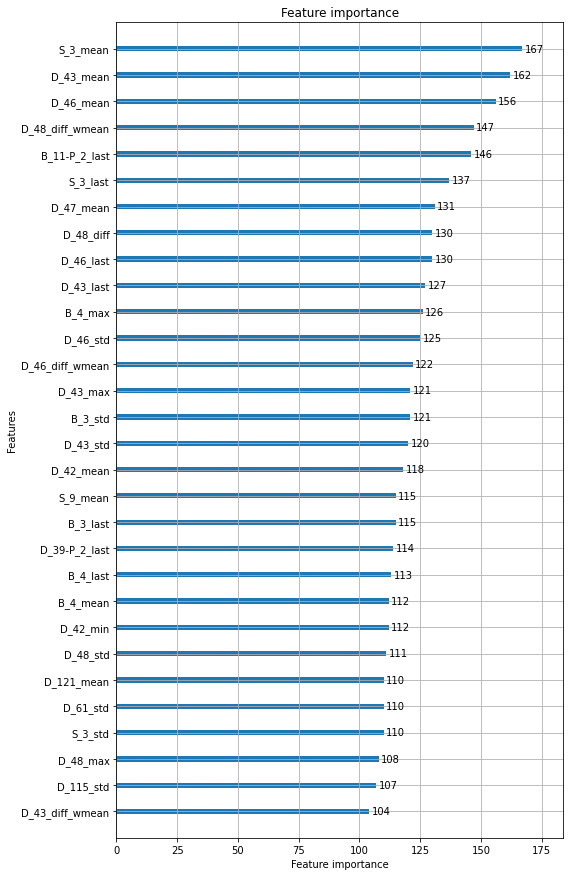

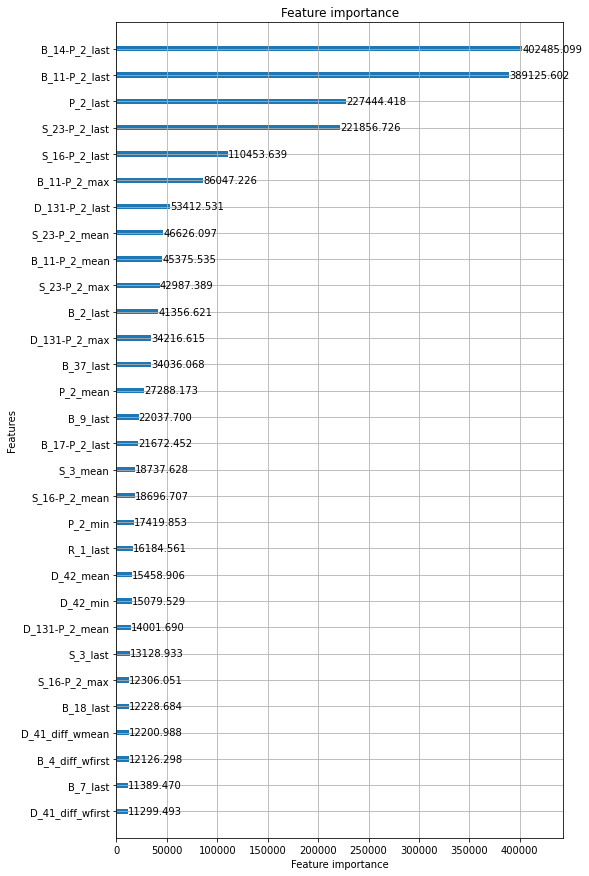

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.759968	valid_0's recall_at4: 0.613297	valid_0's norm_gini: 0.906639


[100]	valid_0's amex_metric: 0.771521	valid_0's recall_at4: 0.629455	valid_0's norm_gini: 0.913587


[150]	valid_0's amex_metric: 0.777403	valid_0's recall_at4: 0.63745	valid_0's norm_gini: 0.917357


[200]	valid_0's amex_metric: 0.780774	valid_0's recall_at4: 0.642079	valid_0's norm_gini: 0.91947


[250]	valid_0's amex_metric: 0.783724	valid_0's recall_at4: 0.646707	valid_0's norm_gini: 0.92074


[300]	valid_0's amex_metric: 0.785338	valid_0's recall_at4: 0.649106	valid_0's norm_gini: 0.92157


[350]	valid_0's amex_metric: 0.785927	valid_0's recall_at4: 0.649653	valid_0's norm_gini: 0.9222


[400]	valid_0's amex_metric: 0.786766	valid_0's recall_at4: 0.650873	valid_0's norm_gini: 0.922658


[450]	valid_0's amex_metric: 0.786346	valid_0's recall_at4: 0.649695	valid_0's norm_gini: 0.922996


[500]	valid_0's amex_metric: 0.787011	valid_0's recall_at4: 0.650789	valid_0's norm_gini: 0.923234


[550]	valid_0's amex_metric: 0.787658	valid_0's recall_at4: 0.651841	valid_0's norm_gini: 0.923474


[600]	valid_0's amex_metric: 0.787904	valid_0's recall_at4: 0.652178	valid_0's norm_gini: 0.92363


[650]	valid_0's amex_metric: 0.788482	valid_0's recall_at4: 0.653187	valid_0's norm_gini: 0.923777


[700]	valid_0's amex_metric: 0.788849	valid_0's recall_at4: 0.653777	valid_0's norm_gini: 0.923922


[750]	valid_0's amex_metric: 0.788769	valid_0's recall_at4: 0.653524	valid_0's norm_gini: 0.924013


[800]	valid_0's amex_metric: 0.789087	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.924103


[850]	valid_0's amex_metric: 0.789205	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.924171


[900]	valid_0's amex_metric: 0.789069	valid_0's recall_at4: 0.653903	valid_0's norm_gini: 0.924235


[950]	valid_0's amex_metric: 0.789512	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.924322


[1000]	valid_0's amex_metric: 0.790009	valid_0's recall_at4: 0.655628	valid_0's norm_gini: 0.924391


[1050]	valid_0's amex_metric: 0.790322	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.92447


[1100]	valid_0's amex_metric: 0.790457	valid_0's recall_at4: 0.656428	valid_0's norm_gini: 0.924486


[1150]	valid_0's amex_metric: 0.790334	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.924492


[1200]	valid_0's amex_metric: 0.790479	valid_0's recall_at4: 0.656428	valid_0's norm_gini: 0.924531


[1250]	valid_0's amex_metric: 0.790786	valid_0's recall_at4: 0.657017	valid_0's norm_gini: 0.924556


[1300]	valid_0's amex_metric: 0.790637	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.924594


[1350]	valid_0's amex_metric: 0.791117	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.924586


[1400]	valid_0's amex_metric: 0.790616	valid_0's recall_at4: 0.656638	valid_0's norm_gini: 0.924593


[1450]	valid_0's amex_metric: 0.79192	valid_0's recall_at4: 0.659205	valid_0's norm_gini: 0.924636


[1500]	valid_0's amex_metric: 0.791774	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.924638


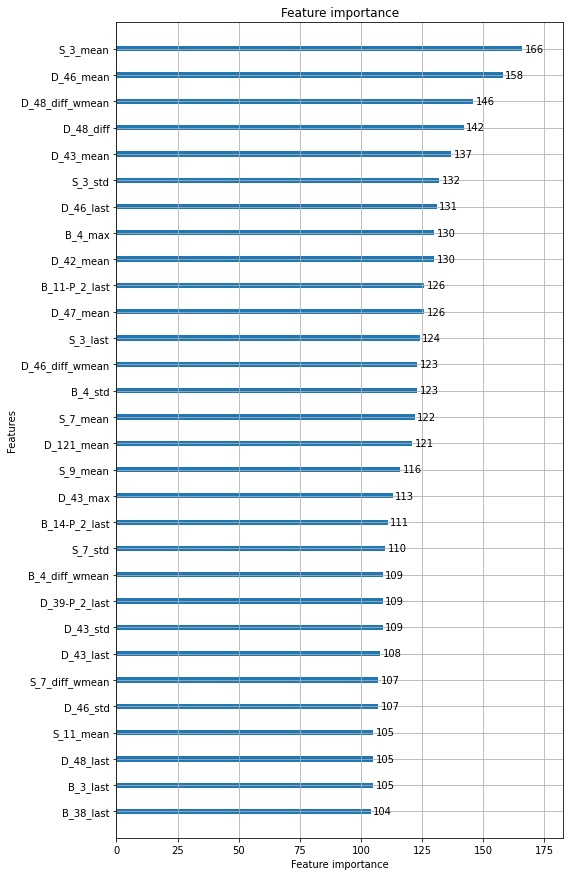

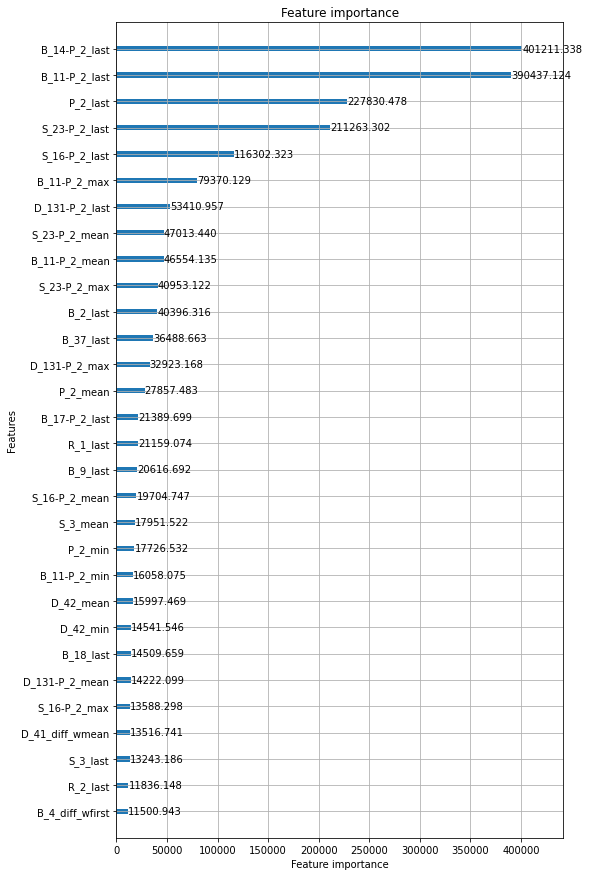

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.76825	valid_0's recall_at4: 0.626299	valid_0's norm_gini: 0.910201


[100]	valid_0's amex_metric: 0.781279	valid_0's recall_at4: 0.645445	valid_0's norm_gini: 0.917113


[150]	valid_0's amex_metric: 0.788351	valid_0's recall_at4: 0.655965	valid_0's norm_gini: 0.920738


[200]	valid_0's amex_metric: 0.791911	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.922724


[250]	valid_0's amex_metric: 0.794065	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.923919


[300]	valid_0's amex_metric: 0.795324	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.924627


[350]	valid_0's amex_metric: 0.796754	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.92513


[400]	valid_0's amex_metric: 0.797504	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925536


[450]	valid_0's amex_metric: 0.797511	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.925761


[500]	valid_0's amex_metric: 0.79804	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925935


[550]	valid_0's amex_metric: 0.79864	valid_0's recall_at4: 0.671197	valid_0's norm_gini: 0.926084


[600]	valid_0's amex_metric: 0.798565	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.92627


[650]	valid_0's amex_metric: 0.79943	valid_0's recall_at4: 0.672544	valid_0's norm_gini: 0.926317


[700]	valid_0's amex_metric: 0.800259	valid_0's recall_at4: 0.674101	valid_0's norm_gini: 0.926418


[750]	valid_0's amex_metric: 0.799797	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.926503


[800]	valid_0's amex_metric: 0.799953	valid_0's recall_at4: 0.673343	valid_0's norm_gini: 0.926563


[850]	valid_0's amex_metric: 0.800146	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.926612


[900]	valid_0's amex_metric: 0.800499	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926645


[950]	valid_0's amex_metric: 0.800139	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.926683


[1000]	valid_0's amex_metric: 0.800233	valid_0's recall_at4: 0.673764	valid_0's norm_gini: 0.926702


[1050]	valid_0's amex_metric: 0.800545	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926737


[1100]	valid_0's amex_metric: 0.800154	valid_0's recall_at4: 0.673554	valid_0's norm_gini: 0.926754


[1150]	valid_0's amex_metric: 0.799991	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.926766


[1200]	valid_0's amex_metric: 0.800124	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.926779


[1250]	valid_0's amex_metric: 0.800373	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.926813


[1300]	valid_0's amex_metric: 0.800424	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.926832


[1350]	valid_0's amex_metric: 0.800335	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.926864


[1400]	valid_0's amex_metric: 0.800191	valid_0's recall_at4: 0.673511	valid_0's norm_gini: 0.926871


[1450]	valid_0's amex_metric: 0.800806	valid_0's recall_at4: 0.674732	valid_0's norm_gini: 0.926879


[1500]	valid_0's amex_metric: 0.800438	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.926901


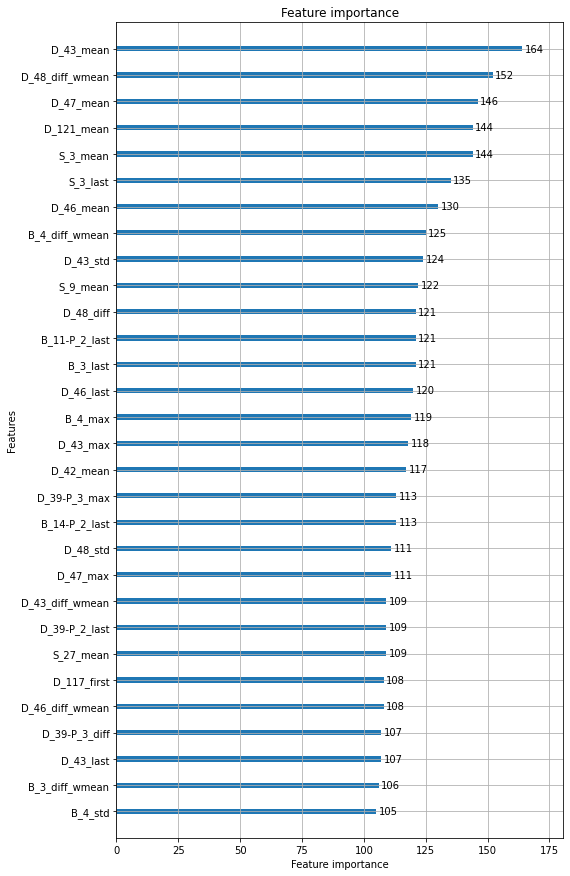

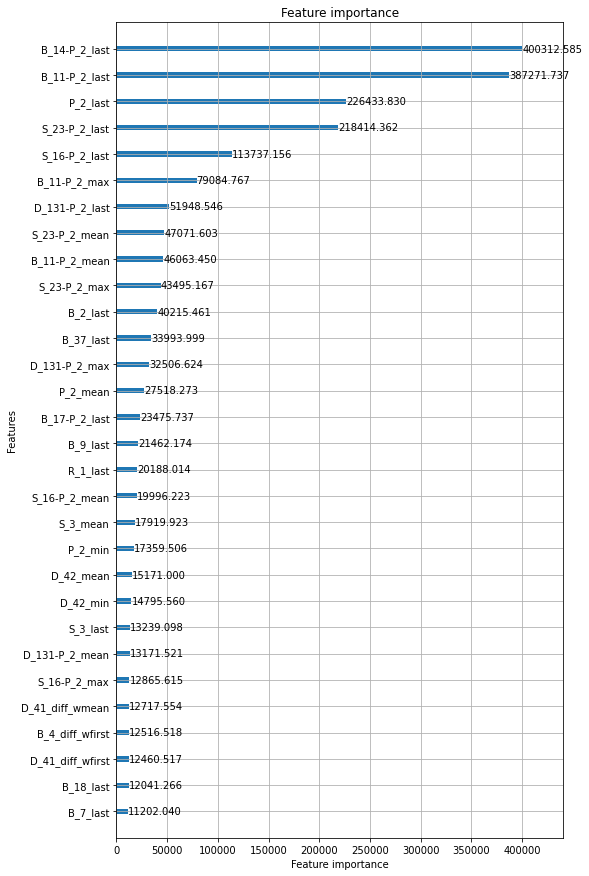

Training time: 25.026848276456196 min.
OOF recall_at4: 0.6645908371764231
OOF normalized_gini: 0.9246925424298087
OOF competition metric: 0.7946416898031159


############################### repeated cross-validation step: 2/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.766877	valid_0's recall_at4: 0.6248	valid_0's norm_gini: 0.908954


[100]	valid_0's amex_metric: 0.778924	valid_0's recall_at4: 0.641925	valid_0's norm_gini: 0.915923


[150]	valid_0's amex_metric: 0.785961	valid_0's recall_at4: 0.652276	valid_0's norm_gini: 0.919646


[200]	valid_0's amex_metric: 0.790612	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.921584


[250]	valid_0's amex_metric: 0.791333	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.922815


[300]	valid_0's amex_metric: 0.793528	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923587


[350]	valid_0's amex_metric: 0.794833	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.924135


[400]	valid_0's amex_metric: 0.795631	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.924552


[450]	valid_0's amex_metric: 0.795656	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924855


[500]	valid_0's amex_metric: 0.795658	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.925027


[550]	valid_0's amex_metric: 0.795232	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.925186


[600]	valid_0's amex_metric: 0.795922	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.925346


[650]	valid_0's amex_metric: 0.796276	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925464


[700]	valid_0's amex_metric: 0.796419	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.925497


[750]	valid_0's amex_metric: 0.796548	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925587


[800]	valid_0's amex_metric: 0.796829	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925644


[850]	valid_0's amex_metric: 0.797183	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.92568


[900]	valid_0's amex_metric: 0.797357	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925733


[950]	valid_0's amex_metric: 0.79765	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925773


[1000]	valid_0's amex_metric: 0.798043	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.9258


[1050]	valid_0's amex_metric: 0.797503	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925857


[1100]	valid_0's amex_metric: 0.796841	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.925879


[1150]	valid_0's amex_metric: 0.796963	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925912


[1200]	valid_0's amex_metric: 0.79661	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925922


[1250]	valid_0's amex_metric: 0.79615	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.925887


[1300]	valid_0's amex_metric: 0.796759	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.925884


[1350]	valid_0's amex_metric: 0.79693	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.925889


[1400]	valid_0's amex_metric: 0.796651	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.925878


[1450]	valid_0's amex_metric: 0.797169	valid_0's recall_at4: 0.668434	valid_0's norm_gini: 0.925904


[1500]	valid_0's amex_metric: 0.797032	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925924


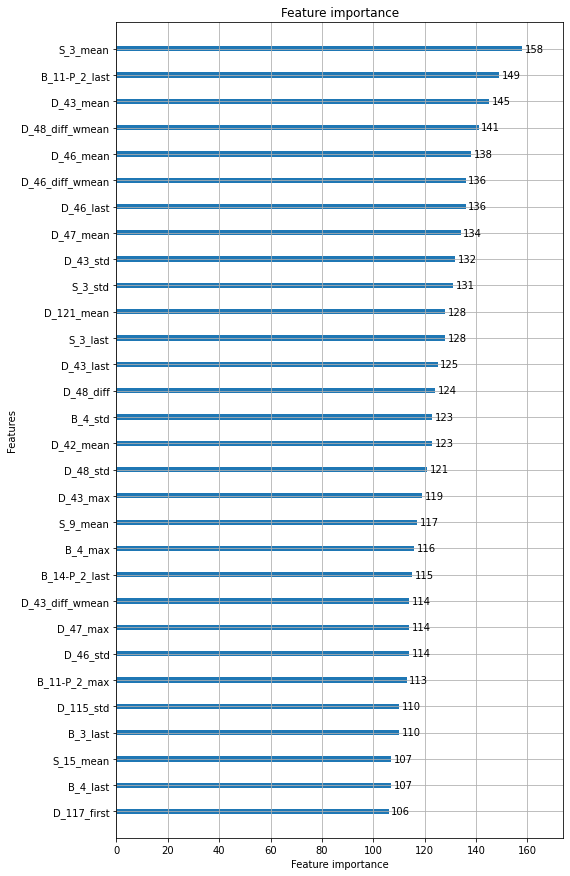

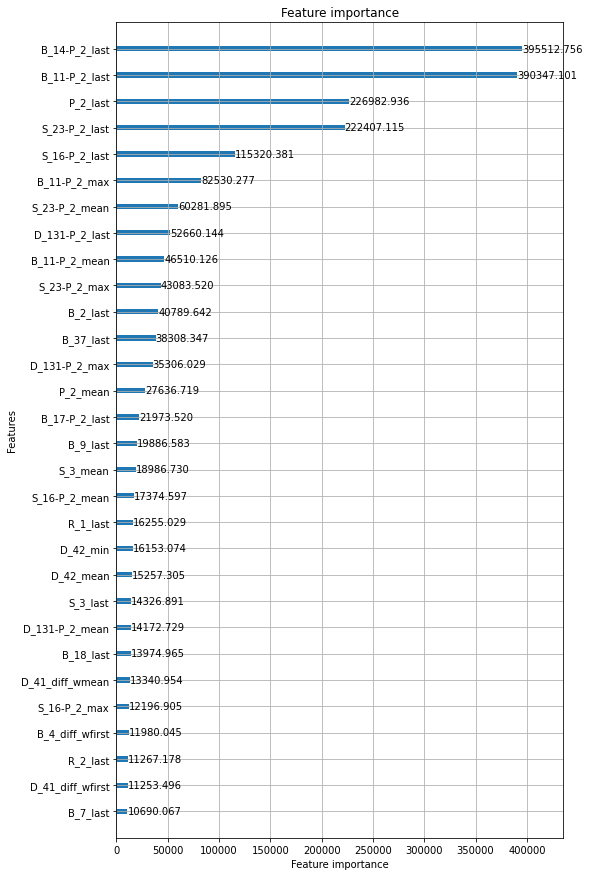

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.76162	valid_0's recall_at4: 0.615375	valid_0's norm_gini: 0.907864


[100]	valid_0's amex_metric: 0.774168	valid_0's recall_at4: 0.633636	valid_0's norm_gini: 0.9147


[150]	valid_0's amex_metric: 0.781399	valid_0's recall_at4: 0.644408	valid_0's norm_gini: 0.918389


[200]	valid_0's amex_metric: 0.78472	valid_0's recall_at4: 0.649121	valid_0's norm_gini: 0.92032


[250]	valid_0's amex_metric: 0.786057	valid_0's recall_at4: 0.650593	valid_0's norm_gini: 0.921522


[300]	valid_0's amex_metric: 0.787799	valid_0's recall_at4: 0.65337	valid_0's norm_gini: 0.922227


[350]	valid_0's amex_metric: 0.787884	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.922776


[400]	valid_0's amex_metric: 0.78962	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.923176


[450]	valid_0's amex_metric: 0.790531	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.923483


[500]	valid_0's amex_metric: 0.791105	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.923665


[550]	valid_0's amex_metric: 0.791027	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.923845


[600]	valid_0's amex_metric: 0.791005	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.92397


[650]	valid_0's amex_metric: 0.791238	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.924056


[700]	valid_0's amex_metric: 0.791475	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.924152


[750]	valid_0's amex_metric: 0.791455	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.924237


[800]	valid_0's amex_metric: 0.792304	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.924295


[850]	valid_0's amex_metric: 0.792377	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.924356


[900]	valid_0's amex_metric: 0.792708	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.924388


[950]	valid_0's amex_metric: 0.792535	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.92442


[1000]	valid_0's amex_metric: 0.792547	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.924487


[1050]	valid_0's amex_metric: 0.792126	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924528


[1100]	valid_0's amex_metric: 0.792366	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.924545


[1150]	valid_0's amex_metric: 0.791578	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.924568


[1200]	valid_0's amex_metric: 0.791967	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.924589


[1250]	valid_0's amex_metric: 0.7921	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.924603


[1300]	valid_0's amex_metric: 0.792532	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.924625


[1350]	valid_0's amex_metric: 0.792284	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.924634


[1400]	valid_0's amex_metric: 0.792522	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.924648


[1450]	valid_0's amex_metric: 0.792273	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.924696


[1500]	valid_0's amex_metric: 0.791631	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.924673


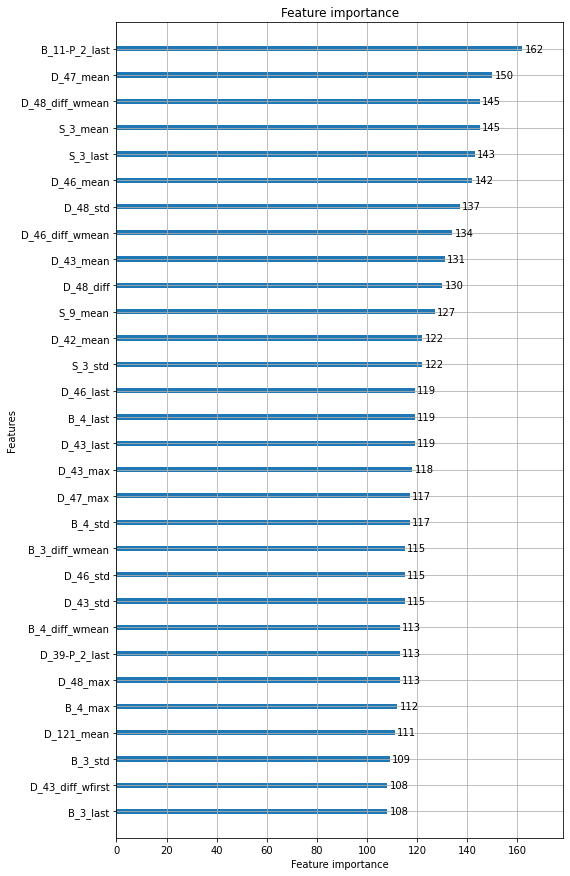

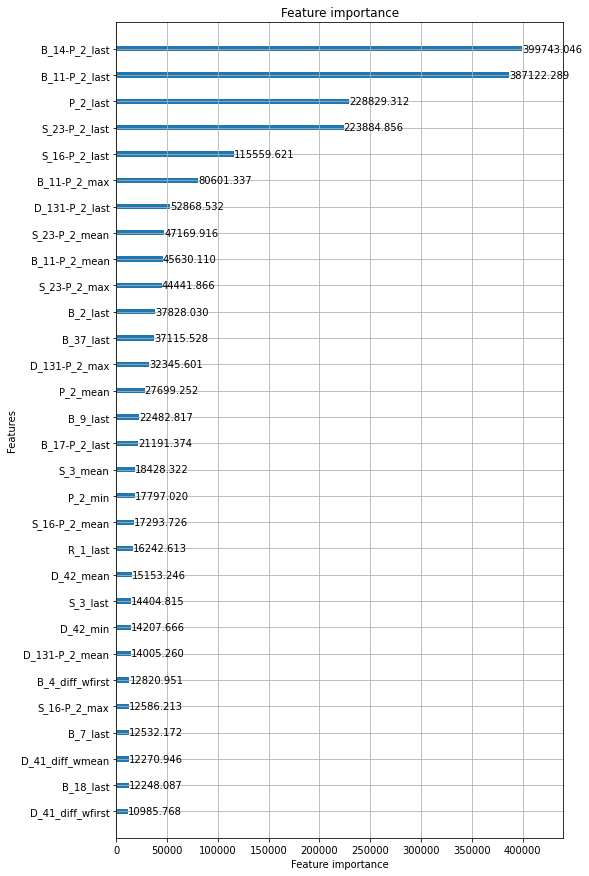

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.760196	valid_0's recall_at4: 0.614071	valid_0's norm_gini: 0.906322


[100]	valid_0's amex_metric: 0.771182	valid_0's recall_at4: 0.628797	valid_0's norm_gini: 0.913567


[150]	valid_0's amex_metric: 0.778033	valid_0's recall_at4: 0.638686	valid_0's norm_gini: 0.91738


[200]	valid_0's amex_metric: 0.782388	valid_0's recall_at4: 0.645292	valid_0's norm_gini: 0.919484


[250]	valid_0's amex_metric: 0.78561	valid_0's recall_at4: 0.650467	valid_0's norm_gini: 0.920752


[300]	valid_0's amex_metric: 0.787897	valid_0's recall_at4: 0.654212	valid_0's norm_gini: 0.921583


[350]	valid_0's amex_metric: 0.788793	valid_0's recall_at4: 0.655432	valid_0's norm_gini: 0.922154


[400]	valid_0's amex_metric: 0.789415	valid_0's recall_at4: 0.656232	valid_0's norm_gini: 0.922598


[450]	valid_0's amex_metric: 0.790244	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.92291


[500]	valid_0's amex_metric: 0.790598	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.923113


[550]	valid_0's amex_metric: 0.791074	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923266


[600]	valid_0's amex_metric: 0.791146	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.923452


[650]	valid_0's amex_metric: 0.790578	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.923535


[700]	valid_0's amex_metric: 0.791284	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923685


[750]	valid_0's amex_metric: 0.791752	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.923779


[800]	valid_0's amex_metric: 0.791414	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.92382


[850]	valid_0's amex_metric: 0.791384	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923885


[900]	valid_0's amex_metric: 0.792405	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.923951


[950]	valid_0's amex_metric: 0.792299	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.924033


[1000]	valid_0's amex_metric: 0.792291	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.924058


[1050]	valid_0's amex_metric: 0.792218	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.92408


[1100]	valid_0's amex_metric: 0.792582	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.924094


[1150]	valid_0's amex_metric: 0.792748	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.92409


[1200]	valid_0's amex_metric: 0.792208	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.924103


[1250]	valid_0's amex_metric: 0.792128	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.924111


[1300]	valid_0's amex_metric: 0.79233	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.924136


[1350]	valid_0's amex_metric: 0.791758	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.924128


[1400]	valid_0's amex_metric: 0.791516	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.924149


[1450]	valid_0's amex_metric: 0.791947	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.92417


[1500]	valid_0's amex_metric: 0.791392	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.924154


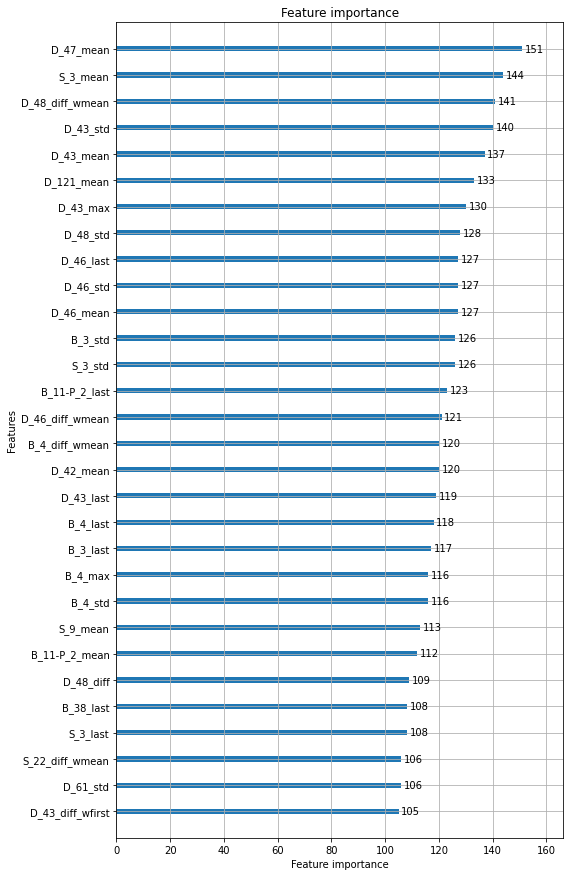

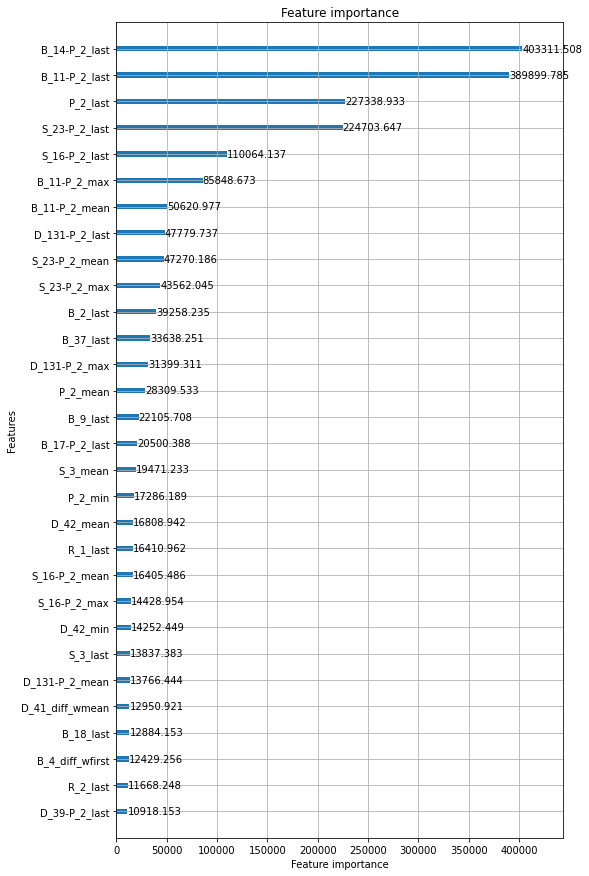

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.765126	valid_0's recall_at4: 0.621713	valid_0's norm_gini: 0.90854


[100]	valid_0's amex_metric: 0.779054	valid_0's recall_at4: 0.642626	valid_0's norm_gini: 0.915482


[150]	valid_0's amex_metric: 0.784819	valid_0's recall_at4: 0.650579	valid_0's norm_gini: 0.91906


[200]	valid_0's amex_metric: 0.788318	valid_0's recall_at4: 0.655628	valid_0's norm_gini: 0.921008


[250]	valid_0's amex_metric: 0.790552	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.922152


[300]	valid_0's amex_metric: 0.792455	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.922887


[350]	valid_0's amex_metric: 0.793791	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.923369


[400]	valid_0's amex_metric: 0.79449	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.9238


[450]	valid_0's amex_metric: 0.795219	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.92408


[500]	valid_0's amex_metric: 0.796101	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.92437


[550]	valid_0's amex_metric: 0.796881	valid_0's recall_at4: 0.669177	valid_0's norm_gini: 0.924586


[600]	valid_0's amex_metric: 0.797103	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.924692


[650]	valid_0's amex_metric: 0.796917	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.924824


[700]	valid_0's amex_metric: 0.796639	valid_0's recall_at4: 0.668336	valid_0's norm_gini: 0.924943


[750]	valid_0's amex_metric: 0.79725	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925028


[800]	valid_0's amex_metric: 0.796794	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925126


[850]	valid_0's amex_metric: 0.79725	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.925195


[900]	valid_0's amex_metric: 0.797665	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.925226


[950]	valid_0's amex_metric: 0.797846	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.925252


[1000]	valid_0's amex_metric: 0.797192	valid_0's recall_at4: 0.669093	valid_0's norm_gini: 0.92529


[1050]	valid_0's amex_metric: 0.797327	valid_0's recall_at4: 0.669346	valid_0's norm_gini: 0.925309


[1100]	valid_0's amex_metric: 0.797731	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925318


[1150]	valid_0's amex_metric: 0.797547	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.925327


[1200]	valid_0's amex_metric: 0.796806	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.92536


[1250]	valid_0's amex_metric: 0.797119	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925398


[1300]	valid_0's amex_metric: 0.797123	valid_0's recall_at4: 0.668883	valid_0's norm_gini: 0.925363


[1350]	valid_0's amex_metric: 0.797292	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925364


[1400]	valid_0's amex_metric: 0.796621	valid_0's recall_at4: 0.667873	valid_0's norm_gini: 0.925369


[1450]	valid_0's amex_metric: 0.796725	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.925367


[1500]	valid_0's amex_metric: 0.797242	valid_0's recall_at4: 0.669093	valid_0's norm_gini: 0.925391


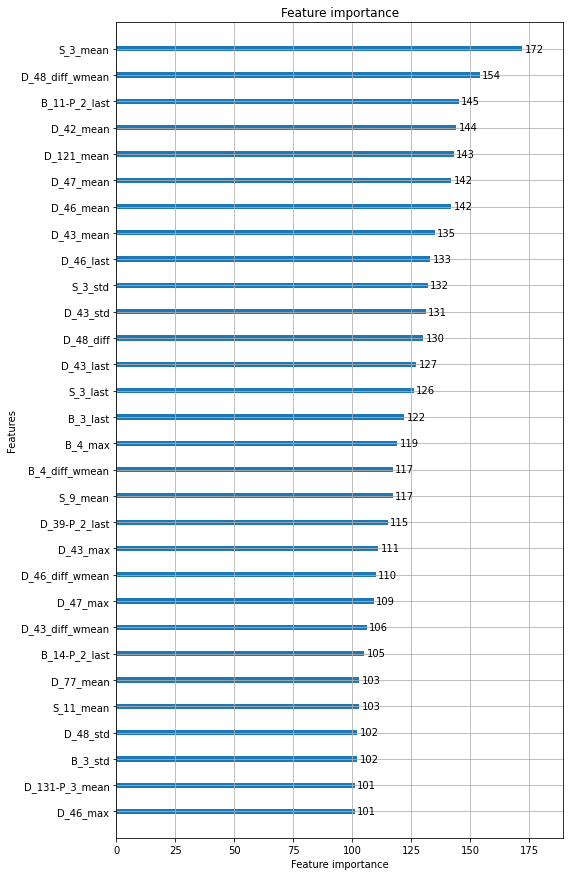

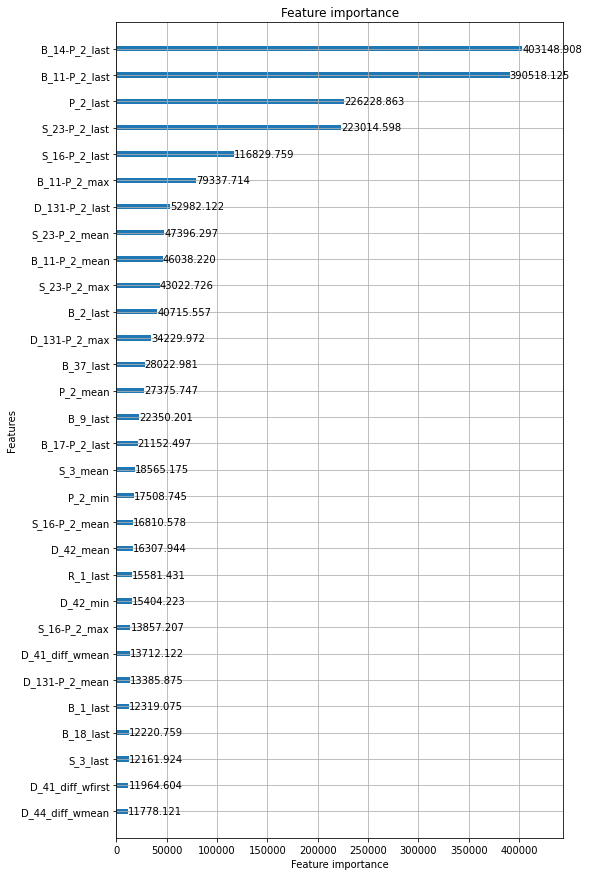

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.766083	valid_0's recall_at4: 0.623312	valid_0's norm_gini: 0.908854


[100]	valid_0's amex_metric: 0.776931	valid_0's recall_at4: 0.638081	valid_0's norm_gini: 0.915781


[150]	valid_0's amex_metric: 0.784024	valid_0's recall_at4: 0.648685	valid_0's norm_gini: 0.919363


[200]	valid_0's amex_metric: 0.788025	valid_0's recall_at4: 0.654829	valid_0's norm_gini: 0.921221


[250]	valid_0's amex_metric: 0.789836	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.922403


[300]	valid_0's amex_metric: 0.791907	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.923136


[350]	valid_0's amex_metric: 0.792712	valid_0's recall_at4: 0.661729	valid_0's norm_gini: 0.923695


[400]	valid_0's amex_metric: 0.792703	valid_0's recall_at4: 0.661351	valid_0's norm_gini: 0.924055


[450]	valid_0's amex_metric: 0.793625	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.924384


[500]	valid_0's amex_metric: 0.793977	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.924584


[550]	valid_0's amex_metric: 0.794789	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.924819


[600]	valid_0's amex_metric: 0.795121	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.924977


[650]	valid_0's amex_metric: 0.795029	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.92513


[700]	valid_0's amex_metric: 0.795355	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.925235


[750]	valid_0's amex_metric: 0.795332	valid_0's recall_at4: 0.665348	valid_0's norm_gini: 0.925316


[800]	valid_0's amex_metric: 0.795637	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.925421


[850]	valid_0's amex_metric: 0.795531	valid_0's recall_at4: 0.665559	valid_0's norm_gini: 0.925503


[900]	valid_0's amex_metric: 0.795854	valid_0's recall_at4: 0.66619	valid_0's norm_gini: 0.925519


[950]	valid_0's amex_metric: 0.795835	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925565


[1000]	valid_0's amex_metric: 0.795859	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925613


[1050]	valid_0's amex_metric: 0.795465	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.925666


[1100]	valid_0's amex_metric: 0.795837	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.925695


[1150]	valid_0's amex_metric: 0.796117	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.92575


[1200]	valid_0's amex_metric: 0.795706	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.925768


[1250]	valid_0's amex_metric: 0.796138	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.925835


[1300]	valid_0's amex_metric: 0.796549	valid_0's recall_at4: 0.667242	valid_0's norm_gini: 0.925857


[1350]	valid_0's amex_metric: 0.795955	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.925888


[1400]	valid_0's amex_metric: 0.79661	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925893


[1450]	valid_0's amex_metric: 0.796065	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.925898


[1500]	valid_0's amex_metric: 0.796111	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.925906


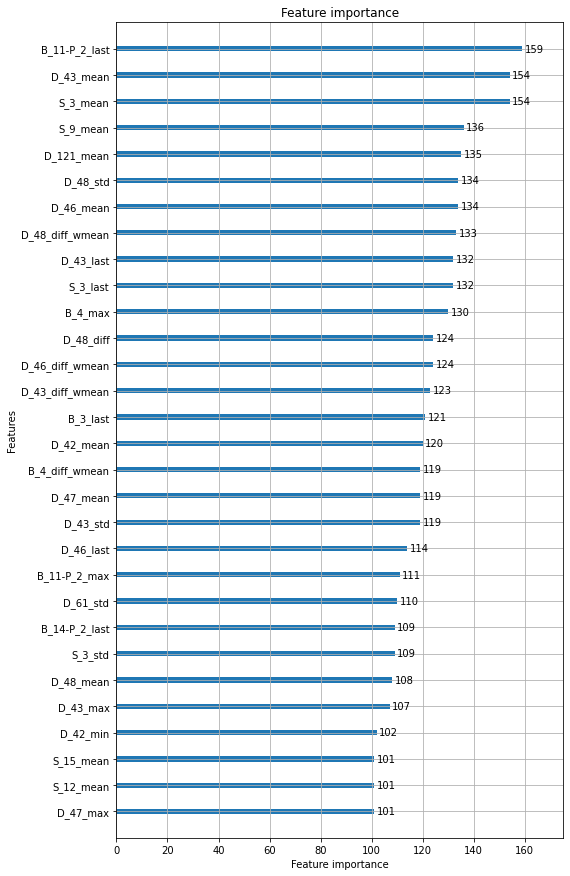

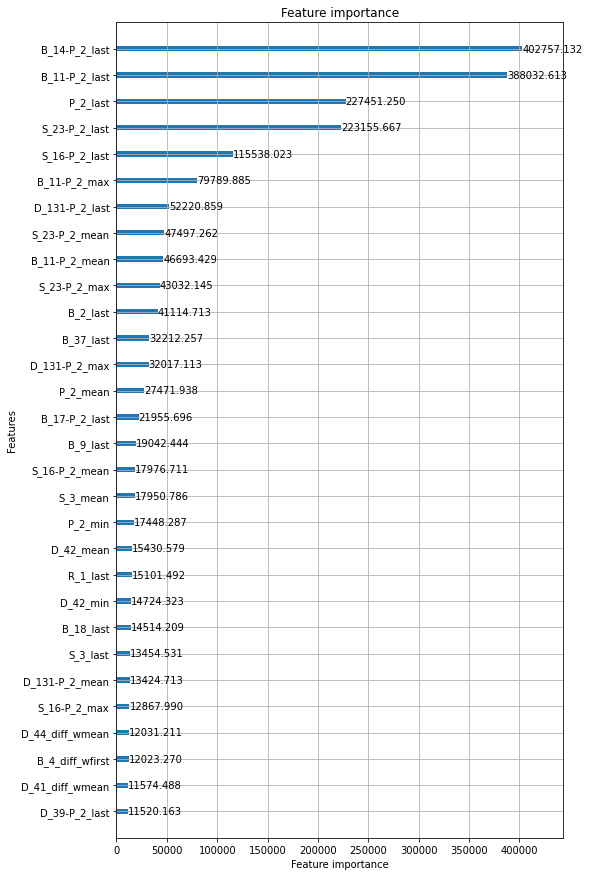

Training time: 25.361674896876018 min.
OOF recall_at4: 0.664287878277847
OOF normalized_gini: 0.9247457675636932
OOF competition metric: 0.7945168229207701


############################### repeated cross-validation step: 3/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.759994	valid_0's recall_at4: 0.613229	valid_0's norm_gini: 0.906758


[100]	valid_0's amex_metric: 0.773627	valid_0's recall_at4: 0.633342	valid_0's norm_gini: 0.913911


[150]	valid_0's amex_metric: 0.780662	valid_0's recall_at4: 0.643777	valid_0's norm_gini: 0.917546


[200]	valid_0's amex_metric: 0.784996	valid_0's recall_at4: 0.650467	valid_0's norm_gini: 0.919525


[250]	valid_0's amex_metric: 0.786619	valid_0's recall_at4: 0.652571	valid_0's norm_gini: 0.920667


[300]	valid_0's amex_metric: 0.788978	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.92143


[350]	valid_0's amex_metric: 0.79	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.921958


[400]	valid_0's amex_metric: 0.790878	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.922369


[450]	valid_0's amex_metric: 0.790902	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.922626


[500]	valid_0's amex_metric: 0.791319	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.922872


[550]	valid_0's amex_metric: 0.791705	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.923055


[600]	valid_0's amex_metric: 0.792376	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.923176


[650]	valid_0's amex_metric: 0.792352	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923298


[700]	valid_0's amex_metric: 0.792726	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.923371


[750]	valid_0's amex_metric: 0.792036	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.923465


[800]	valid_0's amex_metric: 0.792627	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.923511


[850]	valid_0's amex_metric: 0.792064	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923562


[900]	valid_0's amex_metric: 0.792648	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.923594


[950]	valid_0's amex_metric: 0.792395	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.923678


[1000]	valid_0's amex_metric: 0.792965	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.923681


[1050]	valid_0's amex_metric: 0.792567	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.923686


[1100]	valid_0's amex_metric: 0.792478	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.923676


[1150]	valid_0's amex_metric: 0.792366	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923704


[1200]	valid_0's amex_metric: 0.792138	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923711


[1250]	valid_0's amex_metric: 0.792255	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923734


[1300]	valid_0's amex_metric: 0.792156	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923746


[1350]	valid_0's amex_metric: 0.79202	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.923727


[1400]	valid_0's amex_metric: 0.792523	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.923723


[1450]	valid_0's amex_metric: 0.792215	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.923697


[1500]	valid_0's amex_metric: 0.792256	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.923694


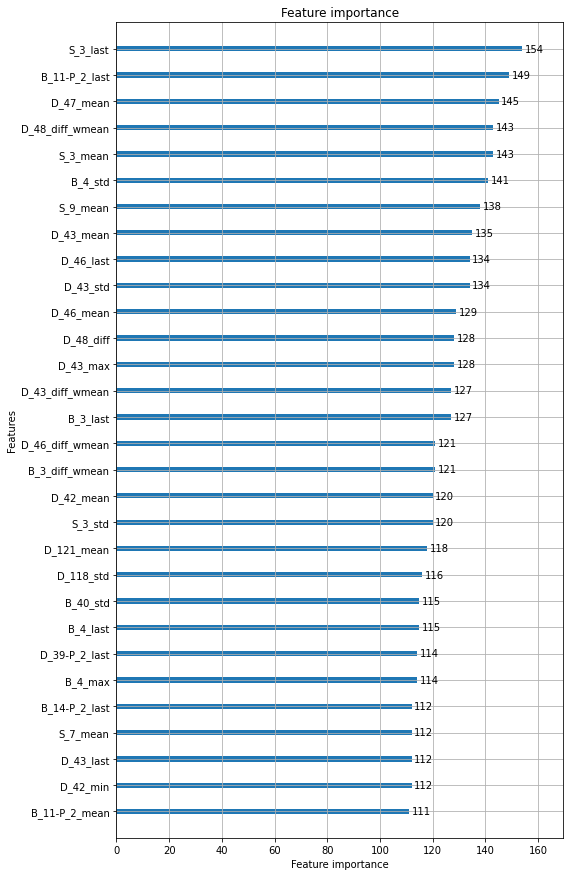

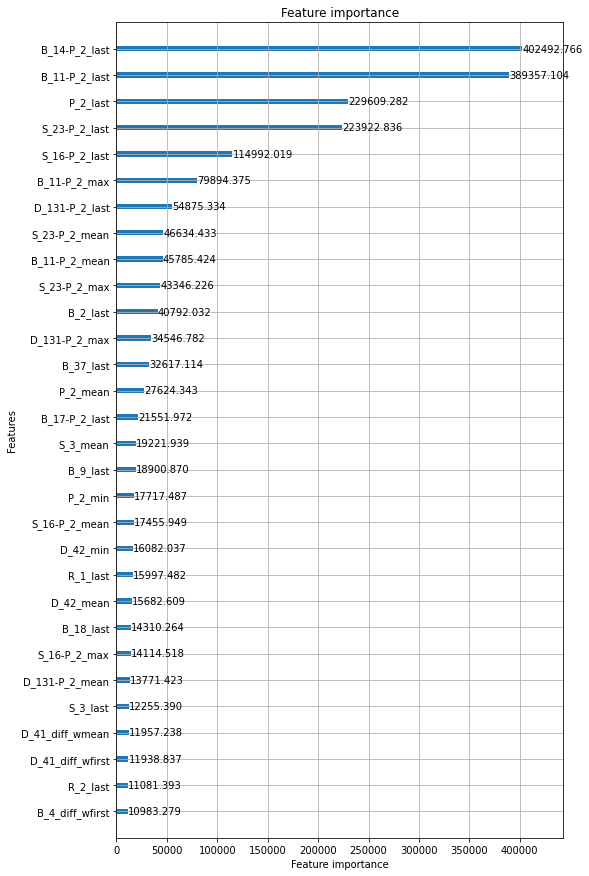

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.76118	valid_0's recall_at4: 0.614239	valid_0's norm_gini: 0.90812


[100]	valid_0's amex_metric: 0.771906	valid_0's recall_at4: 0.628966	valid_0's norm_gini: 0.914847


[150]	valid_0's amex_metric: 0.778371	valid_0's recall_at4: 0.638181	valid_0's norm_gini: 0.918561


[200]	valid_0's amex_metric: 0.781608	valid_0's recall_at4: 0.642725	valid_0's norm_gini: 0.920491


[250]	valid_0's amex_metric: 0.784399	valid_0's recall_at4: 0.647185	valid_0's norm_gini: 0.921613


[300]	valid_0's amex_metric: 0.784543	valid_0's recall_at4: 0.646722	valid_0's norm_gini: 0.922363


[350]	valid_0's amex_metric: 0.785424	valid_0's recall_at4: 0.647942	valid_0's norm_gini: 0.922906


[400]	valid_0's amex_metric: 0.786282	valid_0's recall_at4: 0.649247	valid_0's norm_gini: 0.923318


[450]	valid_0's amex_metric: 0.786926	valid_0's recall_at4: 0.650215	valid_0's norm_gini: 0.923638


[500]	valid_0's amex_metric: 0.787117	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.923894


[550]	valid_0's amex_metric: 0.787983	valid_0's recall_at4: 0.651856	valid_0's norm_gini: 0.92411


[600]	valid_0's amex_metric: 0.788224	valid_0's recall_at4: 0.652234	valid_0's norm_gini: 0.924215


[650]	valid_0's amex_metric: 0.788674	valid_0's recall_at4: 0.652992	valid_0's norm_gini: 0.924357


[700]	valid_0's amex_metric: 0.789124	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.924456


[750]	valid_0's amex_metric: 0.789375	valid_0's recall_at4: 0.65417	valid_0's norm_gini: 0.924581


[800]	valid_0's amex_metric: 0.78955	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.924678


[850]	valid_0's amex_metric: 0.789209	valid_0's recall_at4: 0.653665	valid_0's norm_gini: 0.924753


[900]	valid_0's amex_metric: 0.789852	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.924818


[950]	valid_0's amex_metric: 0.790007	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.924833


[1000]	valid_0's amex_metric: 0.789678	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.924849


[1050]	valid_0's amex_metric: 0.789596	valid_0's recall_at4: 0.654296	valid_0's norm_gini: 0.924897


[1100]	valid_0's amex_metric: 0.789854	valid_0's recall_at4: 0.654759	valid_0's norm_gini: 0.92495


[1150]	valid_0's amex_metric: 0.790289	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.92502


[1200]	valid_0's amex_metric: 0.790289	valid_0's recall_at4: 0.655516	valid_0's norm_gini: 0.925063


[1250]	valid_0's amex_metric: 0.790429	valid_0's recall_at4: 0.655811	valid_0's norm_gini: 0.925046


[1300]	valid_0's amex_metric: 0.789911	valid_0's recall_at4: 0.654759	valid_0's norm_gini: 0.925063


[1350]	valid_0's amex_metric: 0.79068	valid_0's recall_at4: 0.656274	valid_0's norm_gini: 0.925086


[1400]	valid_0's amex_metric: 0.79075	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.925099


[1450]	valid_0's amex_metric: 0.791171	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.9251


[1500]	valid_0's amex_metric: 0.790941	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.925104


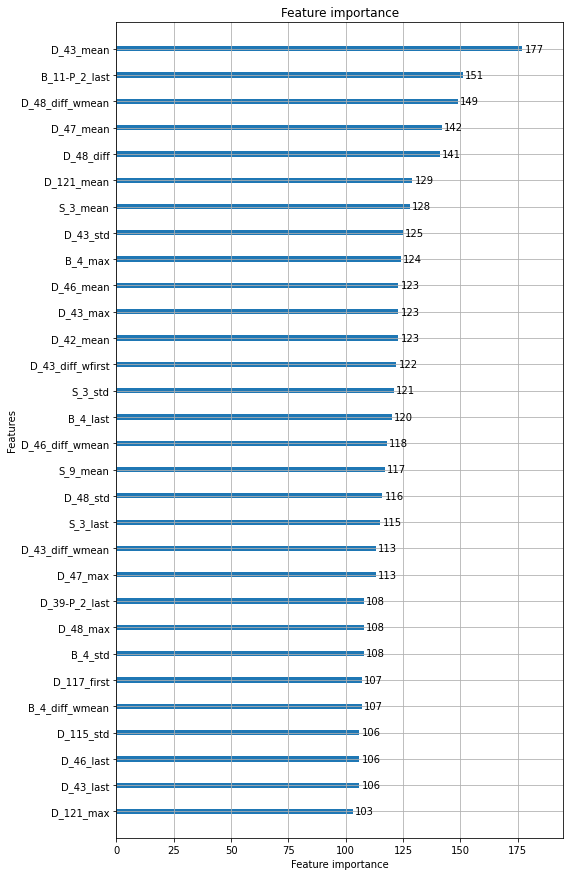

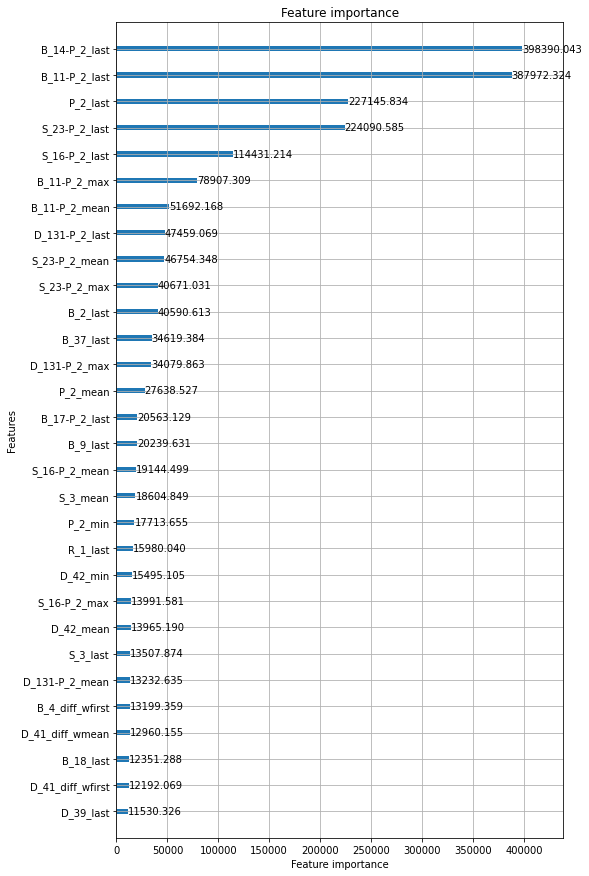

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.764678	valid_0's recall_at4: 0.622276	valid_0's norm_gini: 0.907081


[100]	valid_0's amex_metric: 0.77764	valid_0's recall_at4: 0.640705	valid_0's norm_gini: 0.914575


[150]	valid_0's amex_metric: 0.783742	valid_0's recall_at4: 0.649036	valid_0's norm_gini: 0.918448


[200]	valid_0's amex_metric: 0.787764	valid_0's recall_at4: 0.654969	valid_0's norm_gini: 0.920559


[250]	valid_0's amex_metric: 0.789225	valid_0's recall_at4: 0.656652	valid_0's norm_gini: 0.921798


[300]	valid_0's amex_metric: 0.791511	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.922666


[350]	valid_0's amex_metric: 0.792301	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923194


[400]	valid_0's amex_metric: 0.793577	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923643


[450]	valid_0's amex_metric: 0.794767	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.923919


[500]	valid_0's amex_metric: 0.794991	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924156


[550]	valid_0's amex_metric: 0.795036	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924331


[600]	valid_0's amex_metric: 0.795381	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.924516


[650]	valid_0's amex_metric: 0.796045	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.924708


[700]	valid_0's amex_metric: 0.79639	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924851


[750]	valid_0's amex_metric: 0.796427	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.924967


[800]	valid_0's amex_metric: 0.796916	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.925061


[850]	valid_0's amex_metric: 0.796903	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.92512


[900]	valid_0's amex_metric: 0.797322	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925201


[950]	valid_0's amex_metric: 0.797339	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925277


[1000]	valid_0's amex_metric: 0.797403	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.92532


[1050]	valid_0's amex_metric: 0.797569	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.925359


[1100]	valid_0's amex_metric: 0.797127	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925358


[1150]	valid_0's amex_metric: 0.797483	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.925354


[1200]	valid_0's amex_metric: 0.797151	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925322


[1250]	valid_0's amex_metric: 0.797307	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.925339


[1300]	valid_0's amex_metric: 0.797608	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.925351


[1350]	valid_0's amex_metric: 0.797549	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925359


[1400]	valid_0's amex_metric: 0.797137	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.925335


[1450]	valid_0's amex_metric: 0.797336	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.925355


[1500]	valid_0's amex_metric: 0.797601	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.925337


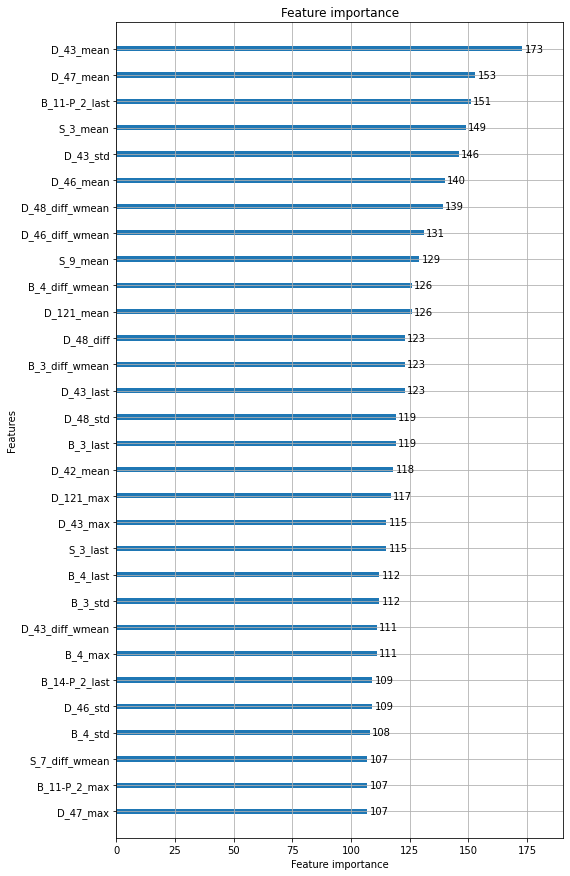

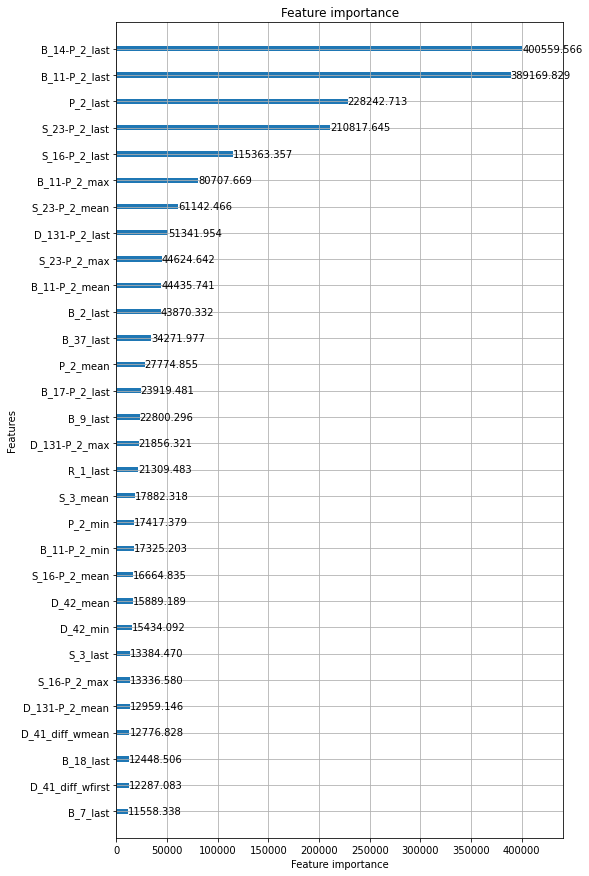

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.769159	valid_0's recall_at4: 0.627435	valid_0's norm_gini: 0.910883


[100]	valid_0's amex_metric: 0.781814	valid_0's recall_at4: 0.645824	valid_0's norm_gini: 0.917805


[150]	valid_0's amex_metric: 0.788575	valid_0's recall_at4: 0.655628	valid_0's norm_gini: 0.921521


[200]	valid_0's amex_metric: 0.792482	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.923529


[250]	valid_0's amex_metric: 0.79486	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924709


[300]	valid_0's amex_metric: 0.795887	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.925457


[350]	valid_0's amex_metric: 0.797554	valid_0's recall_at4: 0.669093	valid_0's norm_gini: 0.926014


[400]	valid_0's amex_metric: 0.798885	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.926447


[450]	valid_0's amex_metric: 0.79984	valid_0's recall_at4: 0.672964	valid_0's norm_gini: 0.926716


[500]	valid_0's amex_metric: 0.800209	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.926948


[550]	valid_0's amex_metric: 0.800622	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.927186


[600]	valid_0's amex_metric: 0.800652	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.927287


[650]	valid_0's amex_metric: 0.80143	valid_0's recall_at4: 0.675447	valid_0's norm_gini: 0.927413


[700]	valid_0's amex_metric: 0.801255	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.927484


[750]	valid_0's amex_metric: 0.801418	valid_0's recall_at4: 0.675279	valid_0's norm_gini: 0.927558


[800]	valid_0's amex_metric: 0.80116	valid_0's recall_at4: 0.67469	valid_0's norm_gini: 0.927631


[850]	valid_0's amex_metric: 0.801291	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927681


[900]	valid_0's amex_metric: 0.80079	valid_0's recall_at4: 0.67389	valid_0's norm_gini: 0.927689


[950]	valid_0's amex_metric: 0.801406	valid_0's recall_at4: 0.675068	valid_0's norm_gini: 0.927744


[1000]	valid_0's amex_metric: 0.801875	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927798


[1050]	valid_0's amex_metric: 0.801409	valid_0's recall_at4: 0.674984	valid_0's norm_gini: 0.927834


[1100]	valid_0's amex_metric: 0.80161	valid_0's recall_at4: 0.675363	valid_0's norm_gini: 0.927857


[1150]	valid_0's amex_metric: 0.801438	valid_0's recall_at4: 0.674984	valid_0's norm_gini: 0.927891


[1200]	valid_0's amex_metric: 0.801844	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.927946


[1250]	valid_0's amex_metric: 0.801565	valid_0's recall_at4: 0.675153	valid_0's norm_gini: 0.927977


[1300]	valid_0's amex_metric: 0.80139	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.928007


[1350]	valid_0's amex_metric: 0.801471	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.928042


[1400]	valid_0's amex_metric: 0.801906	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.928071


[1450]	valid_0's amex_metric: 0.8019	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.928058


[1500]	valid_0's amex_metric: 0.801982	valid_0's recall_at4: 0.675868	valid_0's norm_gini: 0.928096


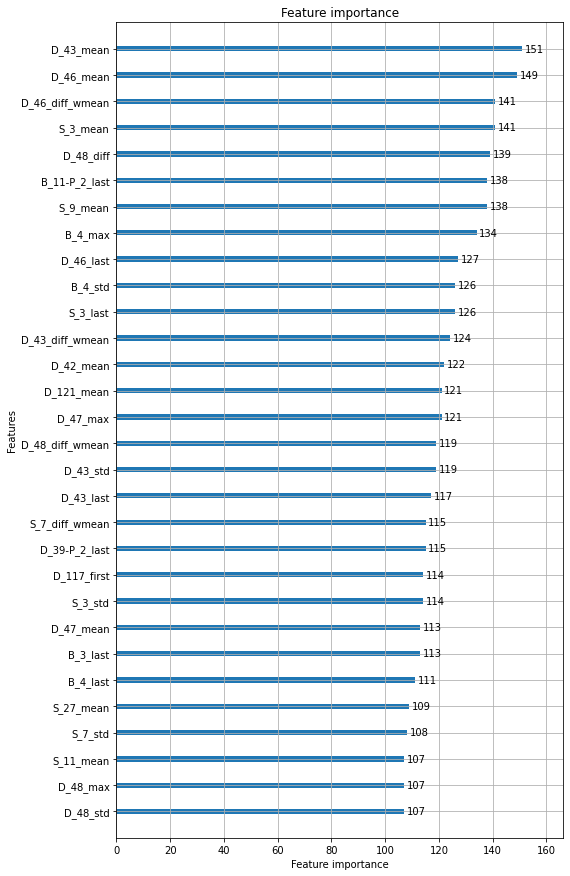

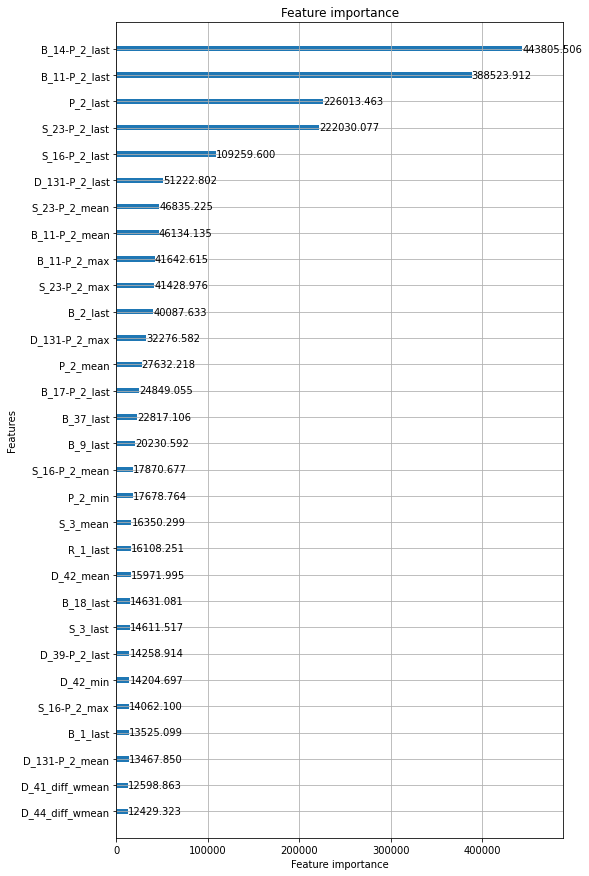

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.764524	valid_0's recall_at4: 0.62146	valid_0's norm_gini: 0.907587


[100]	valid_0's amex_metric: 0.776199	valid_0's recall_at4: 0.637871	valid_0's norm_gini: 0.914527


[150]	valid_0's amex_metric: 0.782659	valid_0's recall_at4: 0.647254	valid_0's norm_gini: 0.918063


[200]	valid_0's amex_metric: 0.785249	valid_0's recall_at4: 0.650494	valid_0's norm_gini: 0.920003


[250]	valid_0's amex_metric: 0.788577	valid_0's recall_at4: 0.656007	valid_0's norm_gini: 0.921148


[300]	valid_0's amex_metric: 0.788975	valid_0's recall_at4: 0.656007	valid_0's norm_gini: 0.921943


[350]	valid_0's amex_metric: 0.790035	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.922421


[400]	valid_0's amex_metric: 0.790004	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.922782


[450]	valid_0's amex_metric: 0.790211	valid_0's recall_at4: 0.657311	valid_0's norm_gini: 0.923112


[500]	valid_0's amex_metric: 0.790694	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.92332


[550]	valid_0's amex_metric: 0.790966	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.923485


[600]	valid_0's amex_metric: 0.791753	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.923629


[650]	valid_0's amex_metric: 0.791463	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.923763


[700]	valid_0's amex_metric: 0.791808	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923864


[750]	valid_0's amex_metric: 0.791982	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.92396


[800]	valid_0's amex_metric: 0.792359	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.92404


[850]	valid_0's amex_metric: 0.792692	valid_0's recall_at4: 0.661267	valid_0's norm_gini: 0.924118


[900]	valid_0's amex_metric: 0.793213	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924149


[950]	valid_0's amex_metric: 0.793015	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.924174


[1000]	valid_0's amex_metric: 0.793496	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.92421


[1050]	valid_0's amex_metric: 0.793231	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.924229


[1100]	valid_0's amex_metric: 0.793579	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.92425


[1150]	valid_0's amex_metric: 0.793256	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924235


[1200]	valid_0's amex_metric: 0.793276	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.924234


[1250]	valid_0's amex_metric: 0.793066	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.924235


[1300]	valid_0's amex_metric: 0.793242	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.924249


[1350]	valid_0's amex_metric: 0.793211	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.924272


[1400]	valid_0's amex_metric: 0.793483	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924269


[1450]	valid_0's amex_metric: 0.793262	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924248


[1500]	valid_0's amex_metric: 0.793542	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.924261


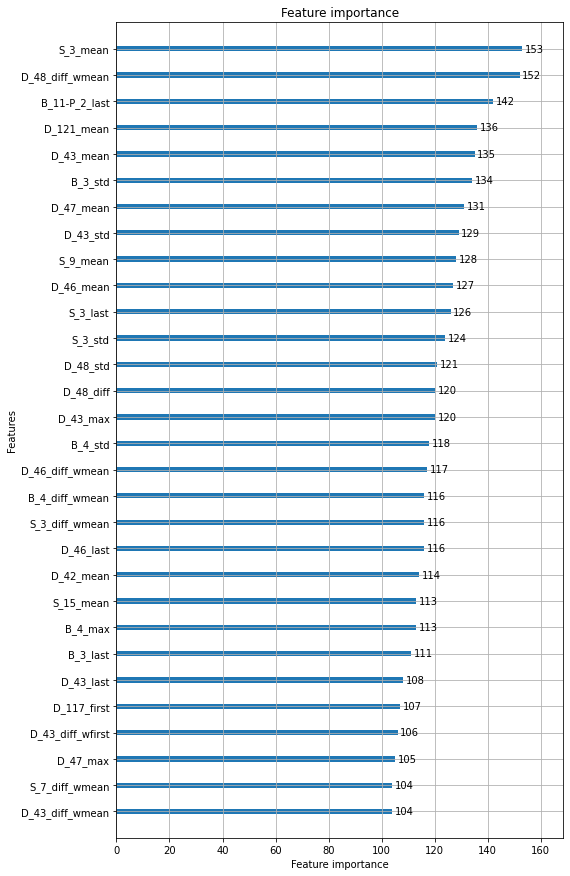

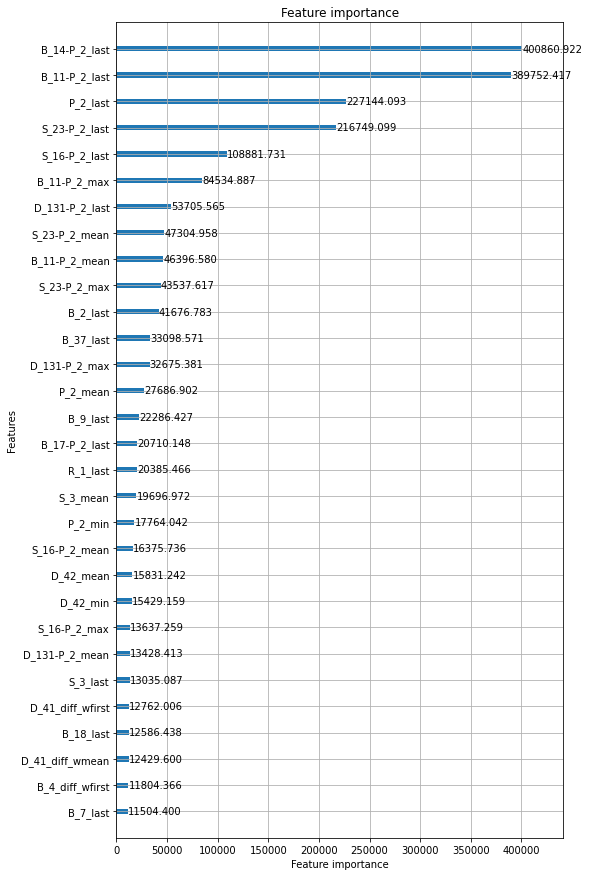

Training time: 25.105149388313293 min.
OOF recall_at4: 0.6650031978994849
OOF normalized_gini: 0.9248321047000445
OOF competition metric: 0.7949176512997647


############################### repeated cross-validation step: 4/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.762027	valid_0's recall_at4: 0.617942	valid_0's norm_gini: 0.906112


[100]	valid_0's amex_metric: 0.773997	valid_0's recall_at4: 0.634436	valid_0's norm_gini: 0.913559


[150]	valid_0's amex_metric: 0.779852	valid_0's recall_at4: 0.64243	valid_0's norm_gini: 0.917274


[200]	valid_0's amex_metric: 0.783183	valid_0's recall_at4: 0.647059	valid_0's norm_gini: 0.919307


[250]	valid_0's amex_metric: 0.785358	valid_0's recall_at4: 0.650173	valid_0's norm_gini: 0.920544


[300]	valid_0's amex_metric: 0.786702	valid_0's recall_at4: 0.65215	valid_0's norm_gini: 0.921254


[350]	valid_0's amex_metric: 0.788029	valid_0's recall_at4: 0.654296	valid_0's norm_gini: 0.921761


[400]	valid_0's amex_metric: 0.78835	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.922152


[450]	valid_0's amex_metric: 0.788719	valid_0's recall_at4: 0.655011	valid_0's norm_gini: 0.922426


[500]	valid_0's amex_metric: 0.78908	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.922601


[550]	valid_0's amex_metric: 0.788726	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.922777


[600]	valid_0's amex_metric: 0.789258	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.922916


[650]	valid_0's amex_metric: 0.789659	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.923002


[700]	valid_0's amex_metric: 0.790187	valid_0's recall_at4: 0.657283	valid_0's norm_gini: 0.92309


[750]	valid_0's amex_metric: 0.789937	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.923137


[800]	valid_0's amex_metric: 0.790088	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.923229


[850]	valid_0's amex_metric: 0.789351	valid_0's recall_at4: 0.655474	valid_0's norm_gini: 0.923227


[900]	valid_0's amex_metric: 0.789487	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.923247


[950]	valid_0's amex_metric: 0.789936	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.923304


[1000]	valid_0's amex_metric: 0.789754	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.92336


[1050]	valid_0's amex_metric: 0.790493	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.923366


[1100]	valid_0's amex_metric: 0.790718	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.923395


[1150]	valid_0's amex_metric: 0.790993	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.92344


[1200]	valid_0's amex_metric: 0.790737	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.923432


[1250]	valid_0's amex_metric: 0.790669	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.923466


[1300]	valid_0's amex_metric: 0.790689	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.923463


[1350]	valid_0's amex_metric: 0.790823	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.923479


[1400]	valid_0's amex_metric: 0.791557	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.923474


[1450]	valid_0's amex_metric: 0.791434	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.923439


[1500]	valid_0's amex_metric: 0.791396	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.923447


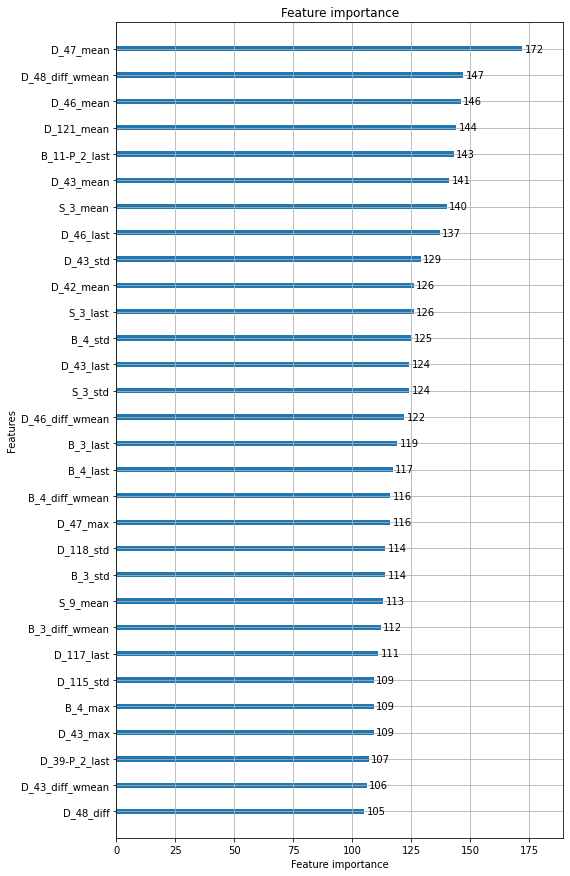

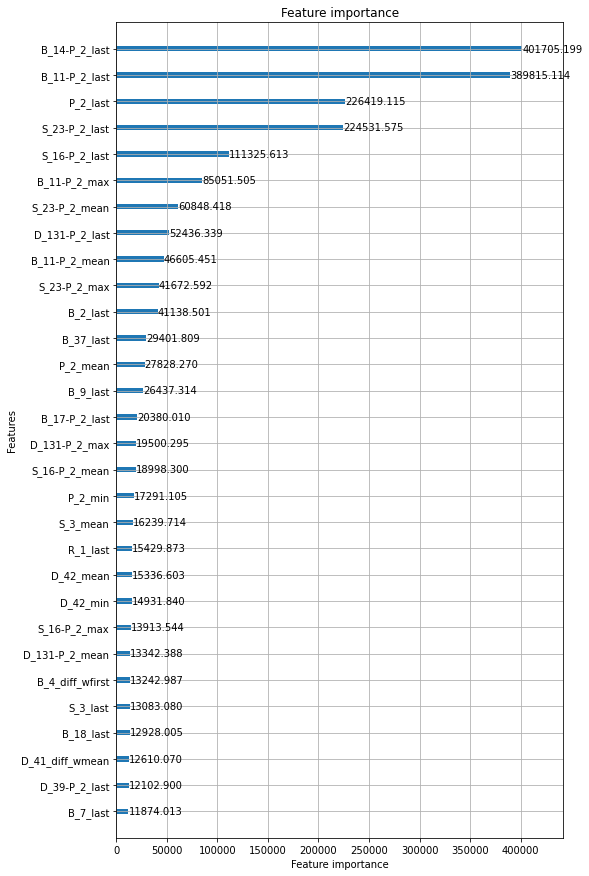

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.765576	valid_0's recall_at4: 0.621729	valid_0's norm_gini: 0.909423


[100]	valid_0's amex_metric: 0.776993	valid_0's recall_at4: 0.637844	valid_0's norm_gini: 0.916141


[150]	valid_0's amex_metric: 0.783609	valid_0's recall_at4: 0.647522	valid_0's norm_gini: 0.919696


[200]	valid_0's amex_metric: 0.78825	valid_0's recall_at4: 0.654843	valid_0's norm_gini: 0.921657


[250]	valid_0's amex_metric: 0.790627	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.922749


[300]	valid_0's amex_metric: 0.791931	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923466


[350]	valid_0's amex_metric: 0.79322	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.923938


[400]	valid_0's amex_metric: 0.794202	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.924346


[450]	valid_0's amex_metric: 0.794875	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.924683


[500]	valid_0's amex_metric: 0.795971	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.924939


[550]	valid_0's amex_metric: 0.796392	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.925107


[600]	valid_0's amex_metric: 0.796638	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.925264


[650]	valid_0's amex_metric: 0.796951	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925385


[700]	valid_0's amex_metric: 0.796982	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.925487


[750]	valid_0's amex_metric: 0.797052	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925586


[800]	valid_0's amex_metric: 0.796513	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.925644


[850]	valid_0's amex_metric: 0.797411	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925673


[900]	valid_0's amex_metric: 0.796749	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925738


[950]	valid_0's amex_metric: 0.79636	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.925759


[1000]	valid_0's amex_metric: 0.79663	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.925794


[1050]	valid_0's amex_metric: 0.796468	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.925848


[1100]	valid_0's amex_metric: 0.796502	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.925875


[1150]	valid_0's amex_metric: 0.796571	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.925886


[1200]	valid_0's amex_metric: 0.796048	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.925892


[1250]	valid_0's amex_metric: 0.796749	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.925905


[1300]	valid_0's amex_metric: 0.797009	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.925921


[1350]	valid_0's amex_metric: 0.79726	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.925917


[1400]	valid_0's amex_metric: 0.79709	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.925915


[1450]	valid_0's amex_metric: 0.797413	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925929


[1500]	valid_0's amex_metric: 0.797561	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.92593


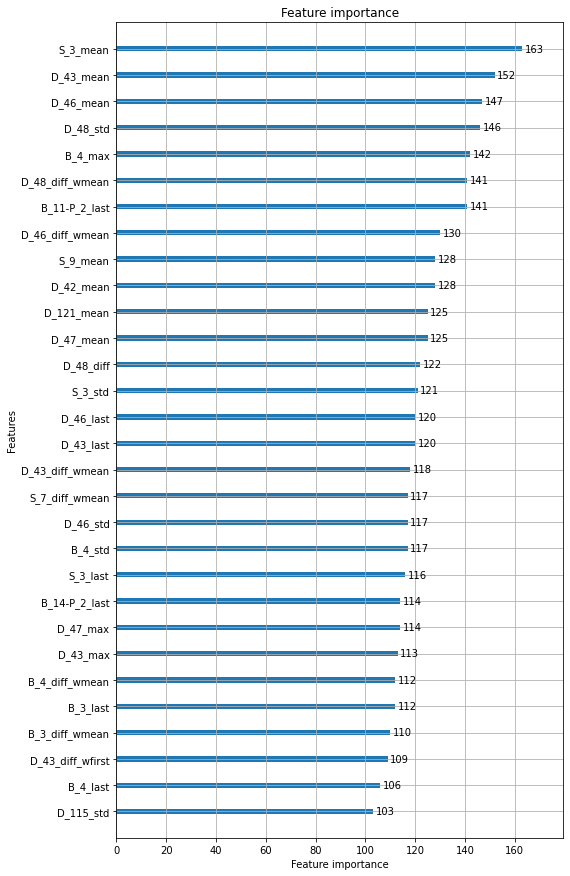

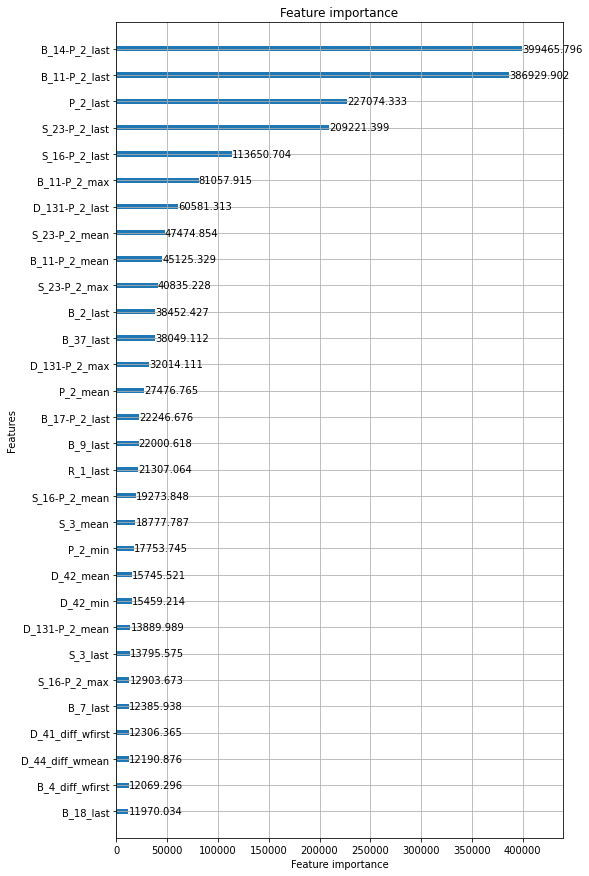

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.764816	valid_0's recall_at4: 0.620172	valid_0's norm_gini: 0.909461


[100]	valid_0's amex_metric: 0.779456	valid_0's recall_at4: 0.64222	valid_0's norm_gini: 0.916693


[150]	valid_0's amex_metric: 0.785851	valid_0's recall_at4: 0.651393	valid_0's norm_gini: 0.920309


[200]	valid_0's amex_metric: 0.789535	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.922334


[250]	valid_0's amex_metric: 0.79247	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923533


[300]	valid_0's amex_metric: 0.794021	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.924321


[350]	valid_0's amex_metric: 0.794643	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924892


[400]	valid_0's amex_metric: 0.795056	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.925298


[450]	valid_0's amex_metric: 0.796467	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925636


[500]	valid_0's amex_metric: 0.797477	valid_0's recall_at4: 0.669065	valid_0's norm_gini: 0.92589


[550]	valid_0's amex_metric: 0.798717	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.926097


[600]	valid_0's amex_metric: 0.799417	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.926235


[650]	valid_0's amex_metric: 0.799392	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926352


[700]	valid_0's amex_metric: 0.799406	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926466


[750]	valid_0's amex_metric: 0.799841	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.926577


[800]	valid_0's amex_metric: 0.799493	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926682


[850]	valid_0's amex_metric: 0.799794	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926736


[900]	valid_0's amex_metric: 0.799402	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926794


[950]	valid_0's amex_metric: 0.799496	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926856


[1000]	valid_0's amex_metric: 0.799455	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926899


[1050]	valid_0's amex_metric: 0.799336	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926915


[1100]	valid_0's amex_metric: 0.79895	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.926942


[1150]	valid_0's amex_metric: 0.799119	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.926943


[1200]	valid_0's amex_metric: 0.799586	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926952


[1250]	valid_0's amex_metric: 0.799753	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926948


[1300]	valid_0's amex_metric: 0.799661	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926932


[1350]	valid_0's amex_metric: 0.800603	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926965


[1400]	valid_0's amex_metric: 0.800748	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.926961


[1450]	valid_0's amex_metric: 0.800242	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.92696


[1500]	valid_0's amex_metric: 0.800167	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.926977


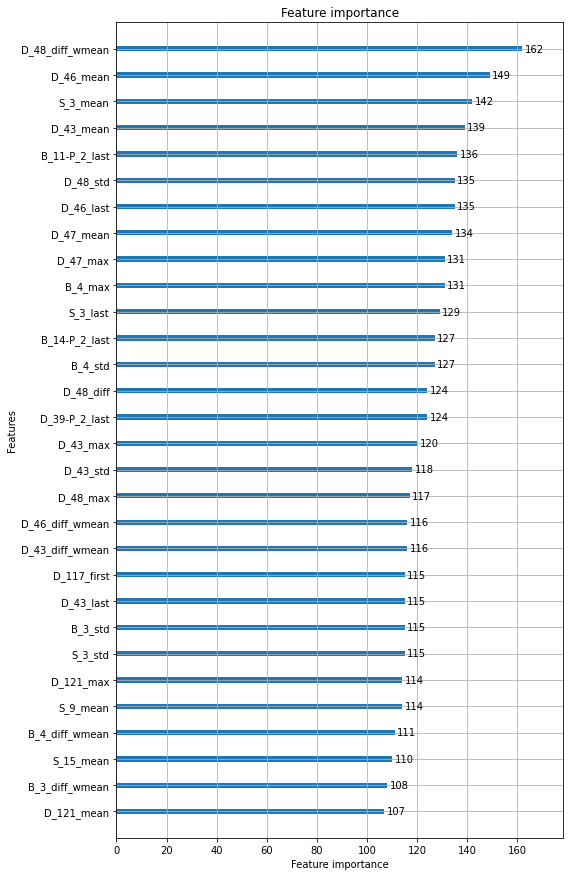

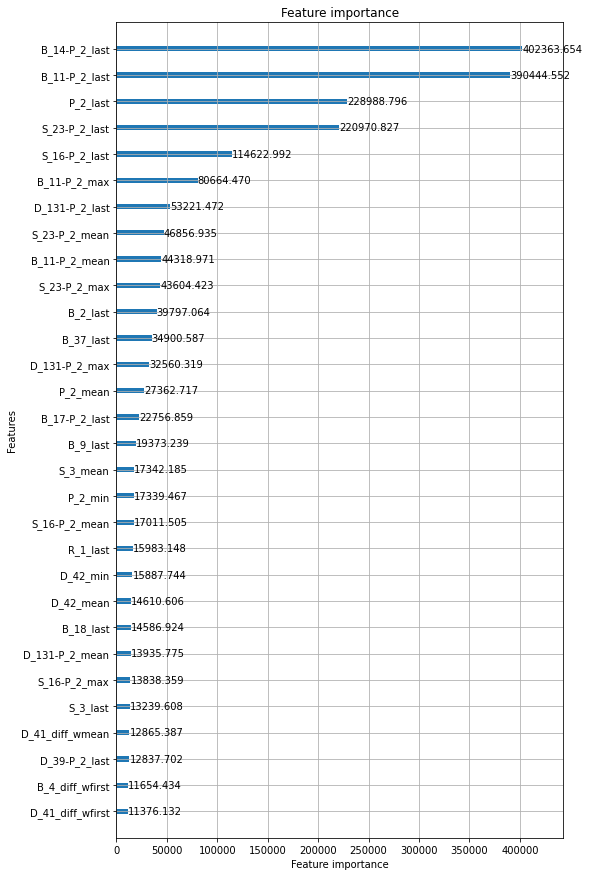

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.764228	valid_0's recall_at4: 0.620534	valid_0's norm_gini: 0.907922


[100]	valid_0's amex_metric: 0.775521	valid_0's recall_at4: 0.636272	valid_0's norm_gini: 0.91477


[150]	valid_0's amex_metric: 0.782236	valid_0's recall_at4: 0.646034	valid_0's norm_gini: 0.918439


[200]	valid_0's amex_metric: 0.785811	valid_0's recall_at4: 0.65121	valid_0's norm_gini: 0.920412


[250]	valid_0's amex_metric: 0.787389	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.921549


[300]	valid_0's amex_metric: 0.789362	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.922339


[350]	valid_0's amex_metric: 0.790994	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.92291


[400]	valid_0's amex_metric: 0.791327	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.923322


[450]	valid_0's amex_metric: 0.791551	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.923646


[500]	valid_0's amex_metric: 0.791946	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.923888


[550]	valid_0's amex_metric: 0.792868	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.92405


[600]	valid_0's amex_metric: 0.793184	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.924259


[650]	valid_0's amex_metric: 0.793156	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.924414


[700]	valid_0's amex_metric: 0.793365	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.924495


[750]	valid_0's amex_metric: 0.793551	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924573


[800]	valid_0's amex_metric: 0.793679	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924661


[850]	valid_0's amex_metric: 0.794368	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.924735


[900]	valid_0's amex_metric: 0.794401	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.9248


[950]	valid_0's amex_metric: 0.794541	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.92487


[1000]	valid_0's amex_metric: 0.794315	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.92488


[1050]	valid_0's amex_metric: 0.794659	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.924896


[1100]	valid_0's amex_metric: 0.795064	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.924948


[1150]	valid_0's amex_metric: 0.795308	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924974


[1200]	valid_0's amex_metric: 0.795799	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.924988


[1250]	valid_0's amex_metric: 0.794953	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.92502


[1300]	valid_0's amex_metric: 0.79492	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.925038


[1350]	valid_0's amex_metric: 0.794936	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.92507


[1400]	valid_0's amex_metric: 0.79432	valid_0's recall_at4: 0.663581	valid_0's norm_gini: 0.925059


[1450]	valid_0's amex_metric: 0.794046	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.925057


[1500]	valid_0's amex_metric: 0.7941	valid_0's recall_at4: 0.66316	valid_0's norm_gini: 0.92504


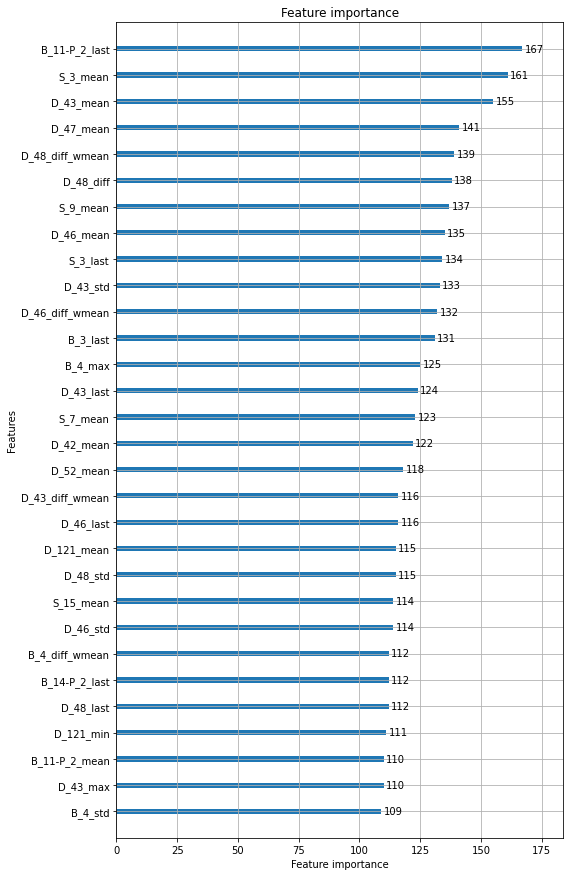

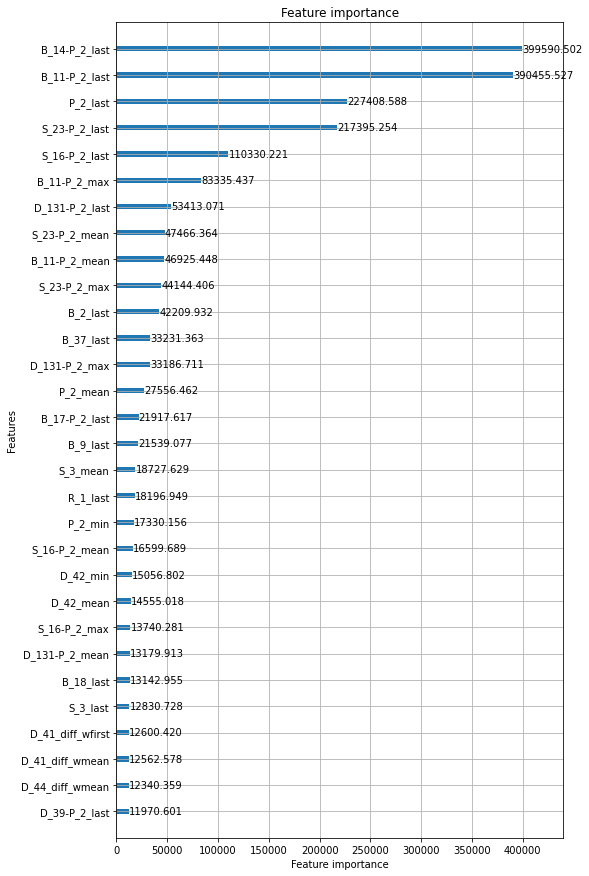

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.761494	valid_0's recall_at4: 0.615948	valid_0's norm_gini: 0.907041


[100]	valid_0's amex_metric: 0.774249	valid_0's recall_at4: 0.63421	valid_0's norm_gini: 0.914288


[150]	valid_0's amex_metric: 0.780226	valid_0's recall_at4: 0.642457	valid_0's norm_gini: 0.917995


[200]	valid_0's amex_metric: 0.784361	valid_0's recall_at4: 0.648685	valid_0's norm_gini: 0.920037


[250]	valid_0's amex_metric: 0.787152	valid_0's recall_at4: 0.653103	valid_0's norm_gini: 0.9212


[300]	valid_0's amex_metric: 0.788097	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.921954


[350]	valid_0's amex_metric: 0.789522	valid_0's recall_at4: 0.656554	valid_0's norm_gini: 0.922489


[400]	valid_0's amex_metric: 0.790678	valid_0's recall_at4: 0.658489	valid_0's norm_gini: 0.922867


[450]	valid_0's amex_metric: 0.791178	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.923194


[500]	valid_0's amex_metric: 0.791224	valid_0's recall_at4: 0.659036	valid_0's norm_gini: 0.923412


[550]	valid_0's amex_metric: 0.791363	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.923606


[600]	valid_0's amex_metric: 0.791725	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923698


[650]	valid_0's amex_metric: 0.791991	valid_0's recall_at4: 0.660173	valid_0's norm_gini: 0.92381


[700]	valid_0's amex_metric: 0.791823	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923894


[750]	valid_0's amex_metric: 0.792737	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.924039


[800]	valid_0's amex_metric: 0.792779	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.924123


[850]	valid_0's amex_metric: 0.793201	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.924211


[900]	valid_0's amex_metric: 0.792762	valid_0's recall_at4: 0.661267	valid_0's norm_gini: 0.924257


[950]	valid_0's amex_metric: 0.792621	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924312


[1000]	valid_0's amex_metric: 0.793042	valid_0's recall_at4: 0.661772	valid_0's norm_gini: 0.924313


[1050]	valid_0's amex_metric: 0.791834	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.924337


[1100]	valid_0's amex_metric: 0.792689	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.924364


[1150]	valid_0's amex_metric: 0.792638	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924387


[1200]	valid_0's amex_metric: 0.792916	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.924397


[1250]	valid_0's amex_metric: 0.792196	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.924388


[1300]	valid_0's amex_metric: 0.792669	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924408


[1350]	valid_0's amex_metric: 0.793033	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.92442


[1400]	valid_0's amex_metric: 0.793124	valid_0's recall_at4: 0.661814	valid_0's norm_gini: 0.924435


[1450]	valid_0's amex_metric: 0.792728	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.924441


[1500]	valid_0's amex_metric: 0.792609	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.924457


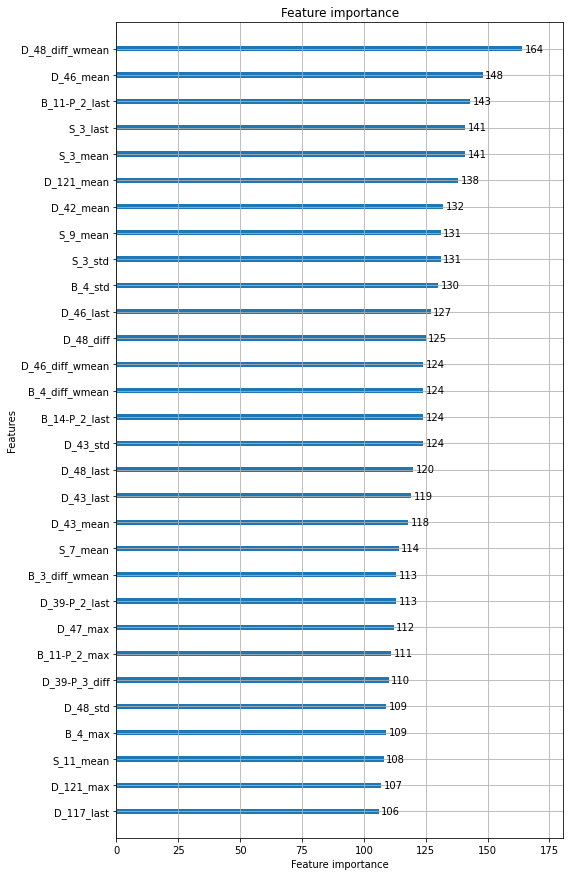

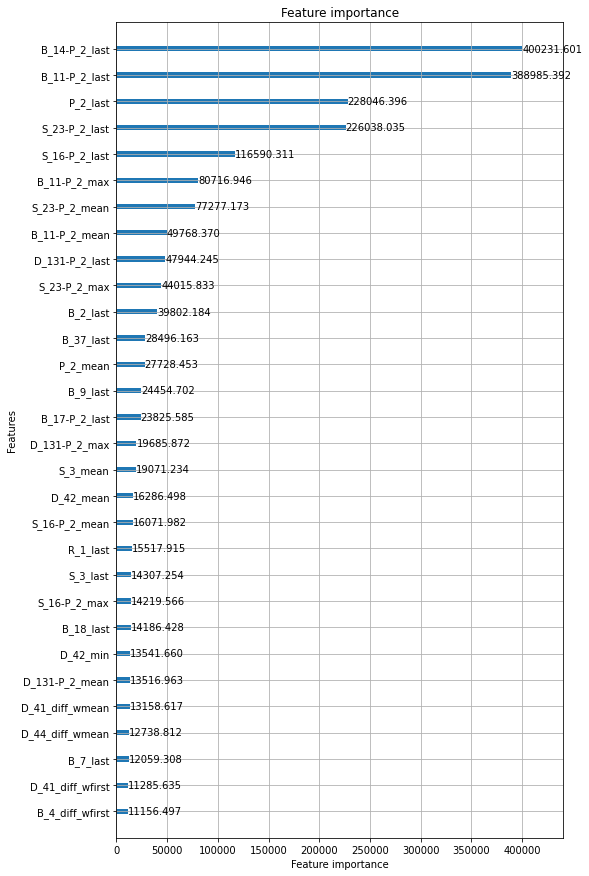

Training time: 25.186479703585306 min.
OOF recall_at4: 0.6648012253004343
OOF normalized_gini: 0.9247114149245697
OOF competition metric: 0.794756320112502


############################### repeated cross-validation step: 5/5 ################################


######################################## training model 1/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.764534	valid_0's recall_at4: 0.620887	valid_0's norm_gini: 0.908182


[100]	valid_0's amex_metric: 0.777567	valid_0's recall_at4: 0.639864	valid_0's norm_gini: 0.91527


[150]	valid_0's amex_metric: 0.783637	valid_0's recall_at4: 0.648321	valid_0's norm_gini: 0.918952


[200]	valid_0's amex_metric: 0.787833	valid_0's recall_at4: 0.654591	valid_0's norm_gini: 0.921075


[250]	valid_0's amex_metric: 0.79127	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.922311


[300]	valid_0's amex_metric: 0.793294	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923119


[350]	valid_0's amex_metric: 0.794196	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.92366


[400]	valid_0's amex_metric: 0.794851	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924088


[450]	valid_0's amex_metric: 0.795835	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.924372


[500]	valid_0's amex_metric: 0.796139	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.92456


[550]	valid_0's amex_metric: 0.796433	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.924727


[600]	valid_0's amex_metric: 0.796408	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924887


[650]	valid_0's amex_metric: 0.796998	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925016


[700]	valid_0's amex_metric: 0.797056	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925131


[750]	valid_0's amex_metric: 0.796916	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.92523


[800]	valid_0's amex_metric: 0.797222	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925294


[850]	valid_0's amex_metric: 0.797599	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925375


[900]	valid_0's amex_metric: 0.797596	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.925411


[950]	valid_0's amex_metric: 0.797371	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.925424


[1000]	valid_0's amex_metric: 0.797569	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.925443


[1050]	valid_0's amex_metric: 0.797301	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925453


[1100]	valid_0's amex_metric: 0.797534	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.925498


[1150]	valid_0's amex_metric: 0.797355	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925518


[1200]	valid_0's amex_metric: 0.796936	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925521


[1250]	valid_0's amex_metric: 0.797465	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925571


[1300]	valid_0's amex_metric: 0.797486	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925571


[1350]	valid_0's amex_metric: 0.797752	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925597


[1400]	valid_0's amex_metric: 0.798333	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925623


[1450]	valid_0's amex_metric: 0.798334	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925626


[1500]	valid_0's amex_metric: 0.798311	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925622


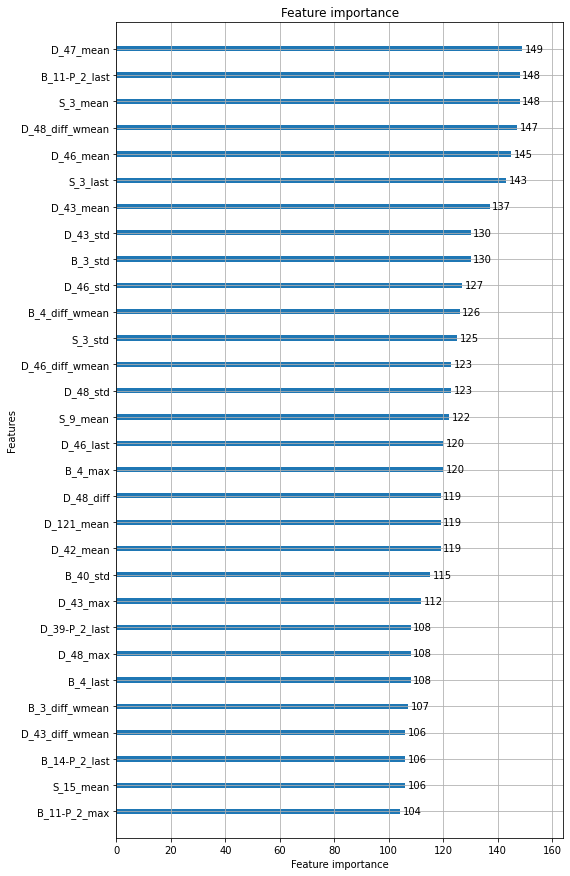

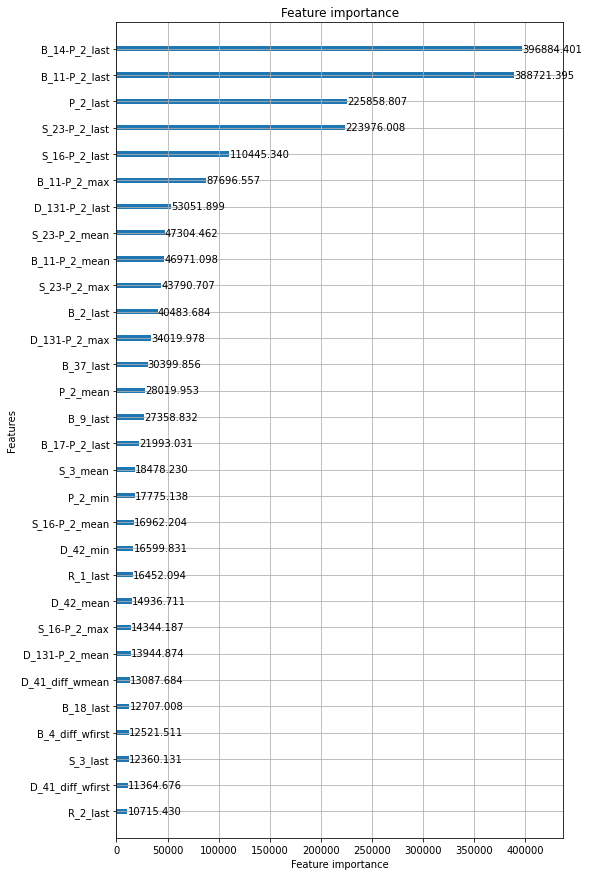

######################################## training model 2/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.768727	valid_0's recall_at4: 0.627535	valid_0's norm_gini: 0.909918


[100]	valid_0's amex_metric: 0.780792	valid_0's recall_at4: 0.644576	valid_0's norm_gini: 0.917008


[150]	valid_0's amex_metric: 0.786512	valid_0's recall_at4: 0.652276	valid_0's norm_gini: 0.920747


[200]	valid_0's amex_metric: 0.791428	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.922753


[250]	valid_0's amex_metric: 0.793971	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.923926


[300]	valid_0's amex_metric: 0.794443	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924703


[350]	valid_0's amex_metric: 0.795535	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.925204


[400]	valid_0's amex_metric: 0.795843	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.925523


[450]	valid_0's amex_metric: 0.796957	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.925816


[500]	valid_0's amex_metric: 0.798205	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.92604


[550]	valid_0's amex_metric: 0.797987	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.926237


[600]	valid_0's amex_metric: 0.799092	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926384


[650]	valid_0's amex_metric: 0.799289	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926484


[700]	valid_0's amex_metric: 0.79894	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.926584


[750]	valid_0's amex_metric: 0.799161	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.926649


[800]	valid_0's amex_metric: 0.799074	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.926727


[850]	valid_0's amex_metric: 0.798853	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.926747


[900]	valid_0's amex_metric: 0.799169	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.926791


[950]	valid_0's amex_metric: 0.79854	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.926795


[1000]	valid_0's amex_metric: 0.798734	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.926805


[1050]	valid_0's amex_metric: 0.798762	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.926818


[1100]	valid_0's amex_metric: 0.799178	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.926809


[1150]	valid_0's amex_metric: 0.799253	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.926832


[1200]	valid_0's amex_metric: 0.7997	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926843


[1250]	valid_0's amex_metric: 0.799295	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926832


[1300]	valid_0's amex_metric: 0.7992	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.926852


[1350]	valid_0's amex_metric: 0.799163	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.926862


[1400]	valid_0's amex_metric: 0.79994	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.92686


[1450]	valid_0's amex_metric: 0.799594	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926842


[1500]	valid_0's amex_metric: 0.799478	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926818


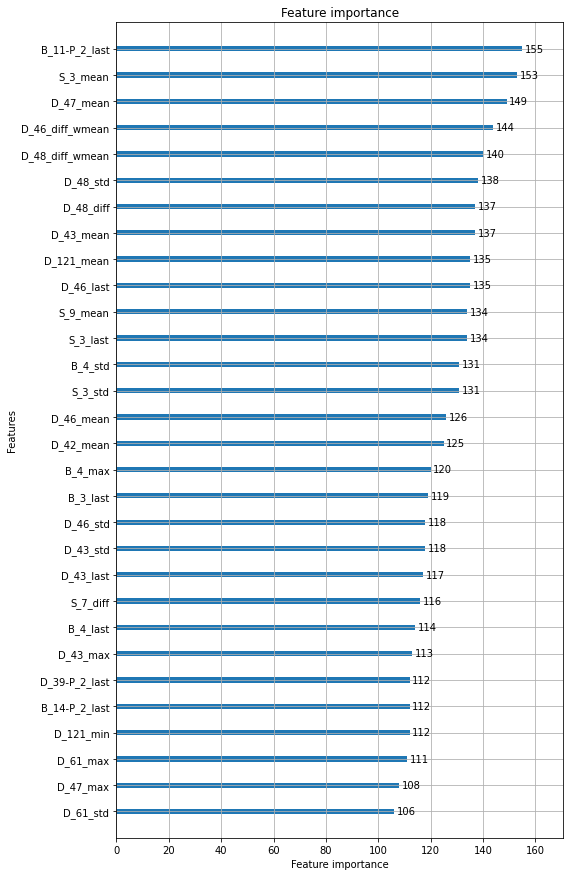

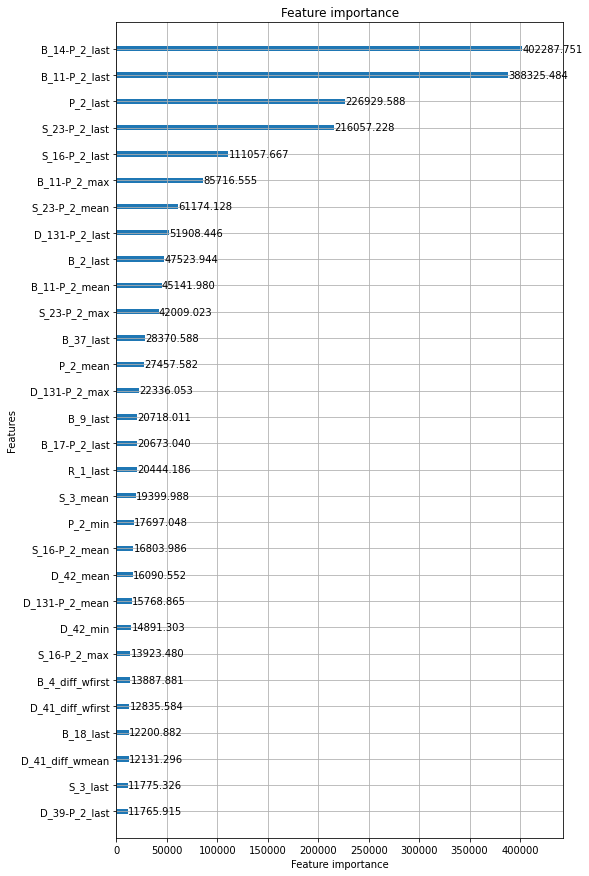

######################################## training model 3/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.761733	valid_0's recall_at4: 0.615459	valid_0's norm_gini: 0.908007


[100]	valid_0's amex_metric: 0.776295	valid_0's recall_at4: 0.637634	valid_0's norm_gini: 0.914956


[150]	valid_0's amex_metric: 0.781991	valid_0's recall_at4: 0.645418	valid_0's norm_gini: 0.918564


[200]	valid_0's amex_metric: 0.784708	valid_0's recall_at4: 0.648952	valid_0's norm_gini: 0.920464


[250]	valid_0's amex_metric: 0.786992	valid_0's recall_at4: 0.652445	valid_0's norm_gini: 0.921539


[300]	valid_0's amex_metric: 0.78821	valid_0's recall_at4: 0.654128	valid_0's norm_gini: 0.922293


[350]	valid_0's amex_metric: 0.788944	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.922835


[400]	valid_0's amex_metric: 0.78976	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.923204


[450]	valid_0's amex_metric: 0.790186	valid_0's recall_at4: 0.656905	valid_0's norm_gini: 0.923468


[500]	valid_0's amex_metric: 0.790517	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.923667


[550]	valid_0's amex_metric: 0.79063	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.923892


[600]	valid_0's amex_metric: 0.790629	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.924102


[650]	valid_0's amex_metric: 0.790674	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.924149


[700]	valid_0's amex_metric: 0.790976	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.924289


[750]	valid_0's amex_metric: 0.791085	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.924381


[800]	valid_0's amex_metric: 0.791241	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.924441


[850]	valid_0's amex_metric: 0.792172	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.924493


[900]	valid_0's amex_metric: 0.791907	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.924553


[950]	valid_0's amex_metric: 0.791594	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.9246


[1000]	valid_0's amex_metric: 0.791748	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.924613


[1050]	valid_0's amex_metric: 0.791894	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.924653


[1100]	valid_0's amex_metric: 0.792125	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.924653


[1150]	valid_0's amex_metric: 0.791849	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.924688


[1200]	valid_0's amex_metric: 0.792276	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.924703


[1250]	valid_0's amex_metric: 0.792579	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.924718


[1300]	valid_0's amex_metric: 0.7927	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.924751


[1350]	valid_0's amex_metric: 0.792568	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.924739


[1400]	valid_0's amex_metric: 0.792421	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.92474


[1450]	valid_0's amex_metric: 0.792242	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.92476


[1500]	valid_0's amex_metric: 0.792564	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.924772


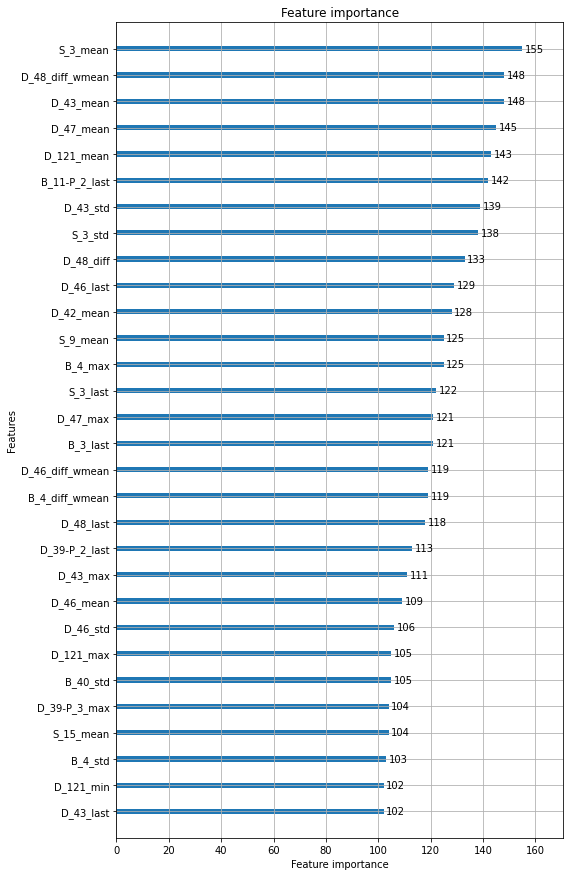

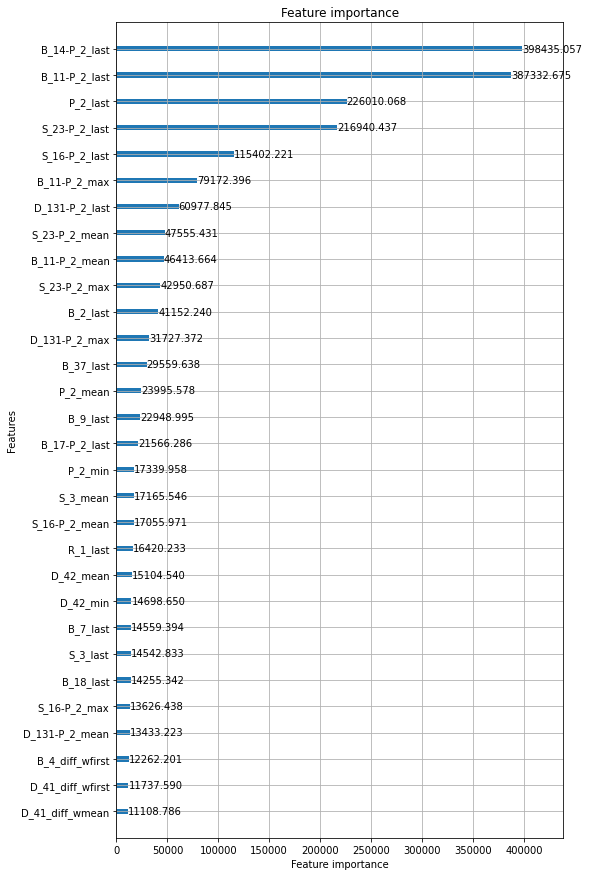

######################################## training model 4/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.764294	valid_0's recall_at4: 0.620661	valid_0's norm_gini: 0.907928


[100]	valid_0's amex_metric: 0.774313	valid_0's recall_at4: 0.633958	valid_0's norm_gini: 0.914669


[150]	valid_0's amex_metric: 0.781229	valid_0's recall_at4: 0.644141	valid_0's norm_gini: 0.918317


[200]	valid_0's amex_metric: 0.786019	valid_0's recall_at4: 0.651715	valid_0's norm_gini: 0.920323


[250]	valid_0's amex_metric: 0.788408	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.921483


[300]	valid_0's amex_metric: 0.789302	valid_0's recall_at4: 0.656343	valid_0's norm_gini: 0.922261


[350]	valid_0's amex_metric: 0.79003	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.922792


[400]	valid_0's amex_metric: 0.79149	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923227


[450]	valid_0's amex_metric: 0.791631	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923511


[500]	valid_0's amex_metric: 0.792073	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.923721


[550]	valid_0's amex_metric: 0.792245	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.923897


[600]	valid_0's amex_metric: 0.792221	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.92406


[650]	valid_0's amex_metric: 0.792322	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924178


[700]	valid_0's amex_metric: 0.793129	valid_0's recall_at4: 0.66194	valid_0's norm_gini: 0.924317


[750]	valid_0's amex_metric: 0.793546	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924395


[800]	valid_0's amex_metric: 0.793235	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.924489


[850]	valid_0's amex_metric: 0.793924	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.924562


[900]	valid_0's amex_metric: 0.794266	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.924614


[950]	valid_0's amex_metric: 0.794618	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.924687


[1000]	valid_0's amex_metric: 0.794851	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924691


[1050]	valid_0's amex_metric: 0.795007	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.924749


[1100]	valid_0's amex_metric: 0.794882	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.924795


[1150]	valid_0's amex_metric: 0.795242	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924841


[1200]	valid_0's amex_metric: 0.794822	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.924843


[1250]	valid_0's amex_metric: 0.794553	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.924852


[1300]	valid_0's amex_metric: 0.794982	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.924868


[1350]	valid_0's amex_metric: 0.795254	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924866


[1400]	valid_0's amex_metric: 0.795249	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924855


[1450]	valid_0's amex_metric: 0.794998	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.924858


[1500]	valid_0's amex_metric: 0.794301	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.924854


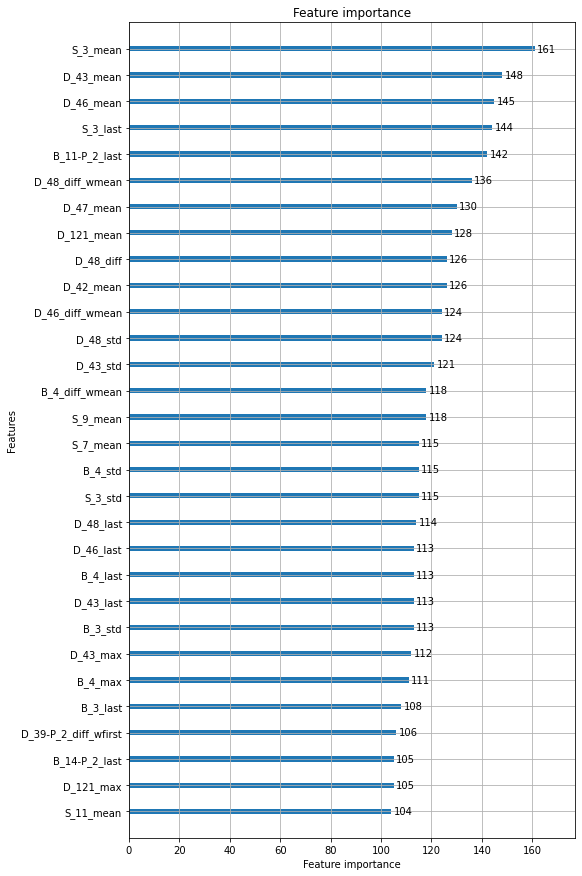

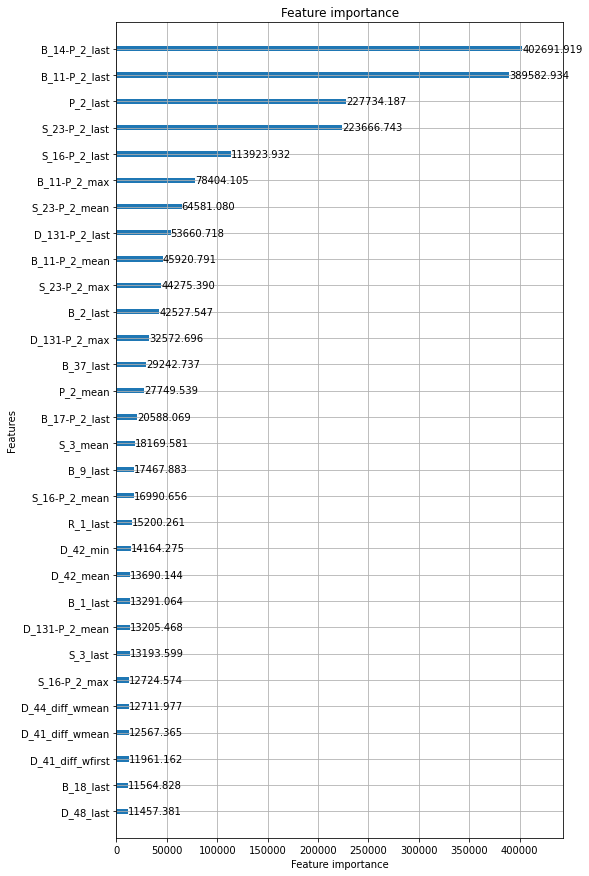

######################################## training model 5/5 ########################################


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


[50]	valid_0's amex_metric: 0.761386	valid_0's recall_at4: 0.616327	valid_0's norm_gini: 0.906445


[100]	valid_0's amex_metric: 0.772074	valid_0's recall_at4: 0.630717	valid_0's norm_gini: 0.91343


[150]	valid_0's amex_metric: 0.778908	valid_0's recall_at4: 0.640564	valid_0's norm_gini: 0.917253


[200]	valid_0's amex_metric: 0.782701	valid_0's recall_at4: 0.64616	valid_0's norm_gini: 0.919242


[250]	valid_0's amex_metric: 0.785575	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.920445


[300]	valid_0's amex_metric: 0.786639	valid_0's recall_at4: 0.652051	valid_0's norm_gini: 0.921227


[350]	valid_0's amex_metric: 0.787404	valid_0's recall_at4: 0.653019	valid_0's norm_gini: 0.921789


[400]	valid_0's amex_metric: 0.788889	valid_0's recall_at4: 0.655544	valid_0's norm_gini: 0.922235


[450]	valid_0's amex_metric: 0.789369	valid_0's recall_at4: 0.656217	valid_0's norm_gini: 0.922521


[500]	valid_0's amex_metric: 0.790187	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.922811


[550]	valid_0's amex_metric: 0.790116	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.923005


[600]	valid_0's amex_metric: 0.790243	valid_0's recall_at4: 0.657311	valid_0's norm_gini: 0.923175


[650]	valid_0's amex_metric: 0.78948	valid_0's recall_at4: 0.65567	valid_0's norm_gini: 0.92329


[700]	valid_0's amex_metric: 0.790119	valid_0's recall_at4: 0.656806	valid_0's norm_gini: 0.923431


[750]	valid_0's amex_metric: 0.789732	valid_0's recall_at4: 0.655965	valid_0's norm_gini: 0.923499


[800]	valid_0's amex_metric: 0.790204	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.92356


[850]	valid_0's amex_metric: 0.790237	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.923625


[900]	valid_0's amex_metric: 0.790046	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.923706


[950]	valid_0's amex_metric: 0.790601	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.923765


[1000]	valid_0's amex_metric: 0.790624	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.923811


[1050]	valid_0's amex_metric: 0.790547	valid_0's recall_at4: 0.657227	valid_0's norm_gini: 0.923866


[1100]	valid_0's amex_metric: 0.791147	valid_0's recall_at4: 0.658363	valid_0's norm_gini: 0.923931


[1150]	valid_0's amex_metric: 0.791434	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923959


[1200]	valid_0's amex_metric: 0.791011	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.923952


[1250]	valid_0's amex_metric: 0.79123	valid_0's recall_at4: 0.658489	valid_0's norm_gini: 0.923971


[1300]	valid_0's amex_metric: 0.792072	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.924013


[1350]	valid_0's amex_metric: 0.791926	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.924017


[1400]	valid_0's amex_metric: 0.791382	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.924021


[1450]	valid_0's amex_metric: 0.79151	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.924026


[1500]	valid_0's amex_metric: 0.791554	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.924029


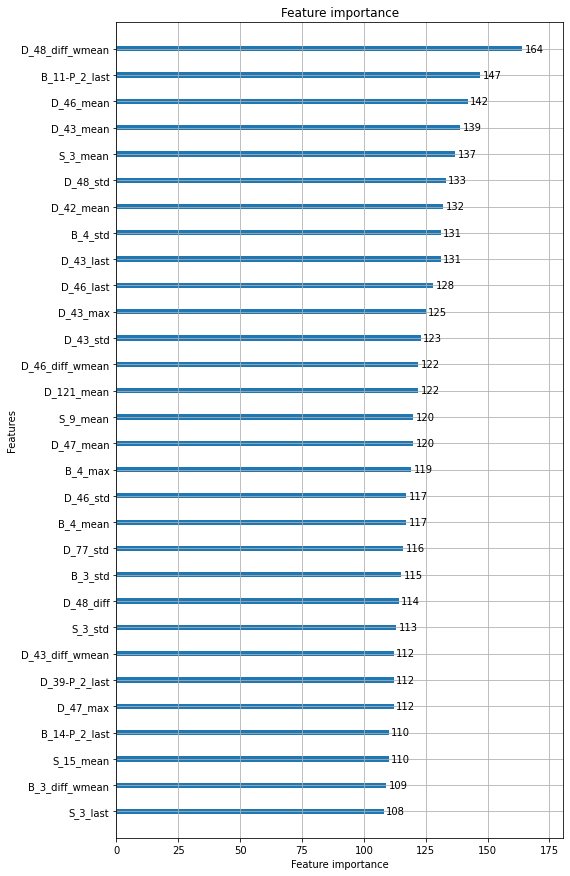

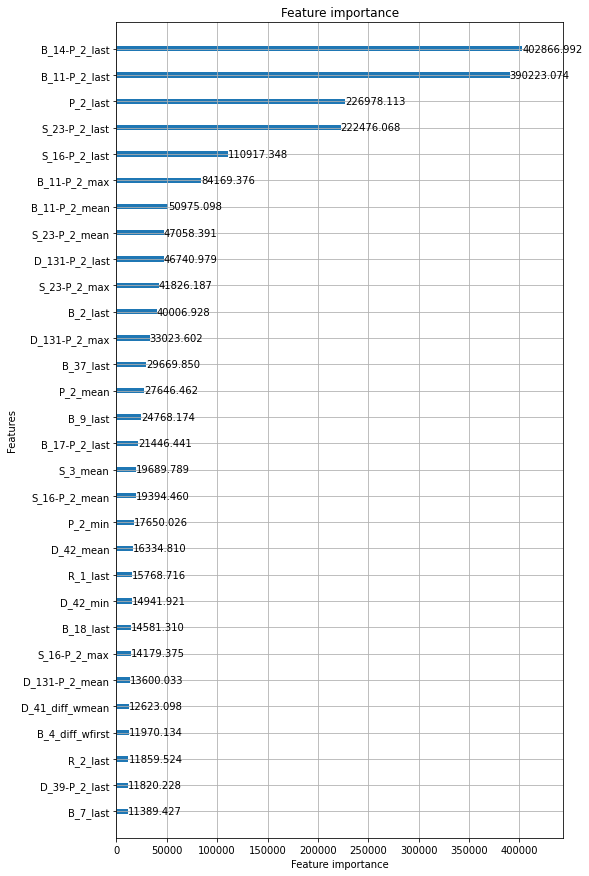

Training time: 25.077514986197155 min.
OOF recall_at4: 0.6654912983471909
OOF normalized_gini: 0.9247549428705599
OOF competition metric: 0.7951231206088754


CPU times: user 14h 31min 53s, sys: 2min 14s, total: 14h 34min 7s
Wall time: 2h 27min 4s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))
    
    if "fold" in train.columns:
        train.drop("fold", axis=1, inplace=True)
    folds = pd.read_parquet(f'../data/processed/cv{repetition}.parquet')
    train = pd.merge(train, folds, how="inner", on="customer_ID")
    
    tic = time.time()
    models,oof = train_models(train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
          
    all_models.extend(models)
    all_oof_dfs.append(oof)
          
    del folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.664591,0.924693,0.794642
1,0.664288,0.924746,0.794517
2,0.665003,0.924832,0.794918
3,0.664801,0.924711,0.794756
4,0.665491,0.924755,0.795123



mean:


recall_at4    0.664835
gini          0.924747
metric        0.794791
dtype: float64


std:


recall_at4    0.000453
gini          0.000054
metric        0.000237
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet("../data/processed/dsv02/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

save_pl = False
path_pl = "../data/subs/lgbm-bce-dsv02-pl/pl/iter0"
all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    imin = repetition*5
    imax = (repetition+1)*5
    
    preds = list()
    for fold,idx in enumerate(range(imin, imax)):
        pred = all_models[idx].predict(test[input_feats])
        if save_pl:
            test["prediction"] = pred
            test[["prediction"]].to_parquet(f"{path_pl}/cv{repetition}/pl-fold{fold}.parquet")
        preds.append(pred)
    all_preds.extend(preds)
       
    test["prediction"] = np.mean(preds, axis=0)
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(f"../data/subs/lgbm-bce-dsv02/submission-cv{repetition}.csv", index=False)

CPU times: user 1h 53min 14s, sys: 1min 31s, total: 1h 54min 46s
Wall time: 18min 12s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(f"../data/subs/lgbm-bce-dsv02/submission-all.csv", index=False)

CPU times: user 3.57 s, sys: 809 ms, total: 4.38 s
Wall time: 4.38 s


***